In [3]:
%%time 
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import bluesquare_data_pipelines.access as blsq
import geopandas as gpd
from shapely.geometry import Point


pdss= blsq.dhis_instance("local_pdss")
snis= blsq.dhis_instance("dhis2_drc_snis_replica")

snis_pdss_map = pd.read_csv("/Users/grlurton/Documents/data/drc/pdss_snis_match/snis_pdss_matches.csv")
%matplotlib inline

Connected we are
Getting Orgunits
Getting Data Elements
Getting Data Element Groups
Getting Orgunits Pyramid
Getting Category Option Combos
Getting Periods
Connected we are
Getting Orgunits
Getting Data Elements
Getting Data Element Groups
Getting Orgunits Pyramid
Getting Category Option Combos
Getting Periods
CPU times: user 734 ms, sys: 251 ms, total: 985 ms
Wall time: 8.91 s


In [2]:
def select_fosa(data, prop, start_date, end_date, exclude_periods = np.nan):
    n_months = pd.date_range(start = pd.to_datetime(start_date,  format='%Y%m'), end = pd.to_datetime(end_date,  format='%Y%m'), freq="M").nunique()
    if ((len(data) > prop*n_months) & (min(data.monthly) == start_date)):
        return data
    
def fill_missing_covariates(data, list_variables):
    data[list_variables] = data[list_variables].fillna(method="ffill")
    return data

def make_interpolated_dataset(data, start_date, end_date):
    data.monthly = pd.to_datetime(data.monthly,  format='%Y%m') + MonthEnd(1)
    date_list = pd.date_range(start = pd.to_datetime(start_date,  format='%Y%m'), end = pd.to_datetime(end_date,  format='%Y%m'), freq="M").tolist()*len(data.uidorgunit.unique())
    fosa_list = sorted(data.uidorgunit.unique().tolist()*len(set(date_list)))
    expectation = pd.DataFrame({"monthly":date_list, "uidorgunit":fosa_list})
    full_dat = data.merge(expectation, how="right")
    full_dat = full_dat.groupby("uidorgunit").apply(fill_missing_covariates,["uidlevel3","uidlevel2","dataelementid","dataelementname","catcomboid","catcomboname"])
    full_dat = full_dat.set_index(["uidlevel2","uidorgunit","monthly"]).groupby(level=0).value.apply(lambda x : x.interpolate())
    return full_dat

In [ ]:
%%capture
%%time
pdss_defs = ['Acceptante nouvelle et renouvellement \(DIU et implant\) - Ver', 'Acceptante nouvelle et renouvellement \(oral & inj\) - Ver', 
             'Enfant complètement vacciné - Ver', 
             'Accouchement assisté - Ver',
             'Consultation Prénatale 4ème visite - Ver', 'Consultation Prénatale 1ère visite - Ver',
             'Consultation Postnatale - Ver',
             ' Consultation externe \(nvx cas\)-ver', 'Consultation Externe \(nvx cas patient indigent\) - plafond 5% - Ver']


snis_defs = ["A 2.1 CPN 1", "A 2.1 CPN 4", "CPN 2", "CPN 3","CPN 4",
             "A 3.1 Nouvelle acceptante PF \(total\)", 
             'DQI Vaccination complète chez l’enfant de moins d’une année \(0-11 mois\) CS', 
             'DQI Consultation Post-Natale CS', 
             'A 2.3 Accouchements par personnel qualifié',
             "Cas suspect", "TDR réalisé",  "TDR positif", "Paludisme simple confirmé", "Paludisme simple confirmé traité \(PN\)", 
             "Paludisme présumé", "Paludisme présumé traité", "Paludisme grave","Paludisme simple confirmé traité selon PN",
             "Paludisme grave traité", 
             "Accouchements","Accouchements par personnel qualifié", "Accouchées référées", "Accouchée avec complications","Accouchements dans la communauté",
             "Fer + acide folique 1ère dose","Fer + acide folique 2ème dose", "Fer + acide folique 3ème dose", "Sulfadox. + Pyrimét ",
             "Femmes enc. avec PB", "Femmes enc. à risque détectées",
             "2.4. Décès liés à l'accouchement" ,"Décès nouveaux nés", "Décès maternels",  "Décès maternels dans la communauté",
             "CPoN",
             "Solde début de mois", "Recettes paiement direct", "Recettes tiers payant", "Autres subsides", "Autres recettes",
             "Salaire de l'Etat", "Prime de l'Etat"]
             
## Take out uselesses
## Add in n walkins
## standardize average consultation cost
             
pdss_ids = pdss.dataelement.uid[pdss.dataelement.name.str.contains('|'.join(pdss_defs))]
snis_ids = snis.dataelement.uid[snis.dataelement.name.str.contains('|'.join(snis_defs))]

pdss_extract = pdss.get_data(pdss_ids, pdss.organisationunit.uid)
snis_extract = snis.get_data(snis_ids, snis.organisationunit.uid)

In [6]:
pdss_extract.dataelementname = pdss_extract.dataelementname.str.lower()
pdss_extract = pdss_extract[(pdss_extract.monthly < "201901") & (pdss_extract.monthly >= "201701")] # & ~(pdss_extract.monthly.isin(["201703","201704"]))]
pdss_extract.value = pdss_extract.value.astype(float)
print("N values in PDSS :" + str(len(pdss_extract)))

snis_extract.dataelementname = snis_extract.dataelementname.str.lower()
snis_extract = snis_extract[(snis_extract.monthly < "201901") & (snis_extract.monthly >= "201701")]
snis_extract.value = snis_extract.value.astype(float)
print("N values in SNIS :" + str(len(snis_extract)))

N values in PDSS :367776
N values in SNIS :12509368


## Financial Data Description

### Amounts paid

* Normalize value by activity
* Imputation

In [ ]:
p = pdss_extract.merge(pdss.orgunitstructure[["uidlevel2","namelevel2"]], left_on="uidlevel2", right_on="uidlevel2")

In [7]:
financial_data = snis_extract[snis_extract.dataelementname.str.contains("recettes|subsides|salaire|prime")]
financial_data_complete = financial_data.groupby("uidorgunit").apply(select_fosa, .8, "201701","201901")

While selecting facilities with at least 80% completeness on financial data, we have to drop 37% of the facilities in the system, which make up for 22% of the data being reported on facilities incomes.

In [214]:
print("% data dropped : " + str(100 - np.round(100*len(financial_data_complete) / len(financial_data), 1)) + "%")
print("% FOSA dropped : " + str(100 - np.round(100 * financial_data_complete.uidorgunit.nunique() / financial_data.uidorgunit.nunique(),1)) + "%")

% data dropped : 21.599999999999994%
% FOSA dropped : 36.8%


/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Total Amout of OOP payments by Province')

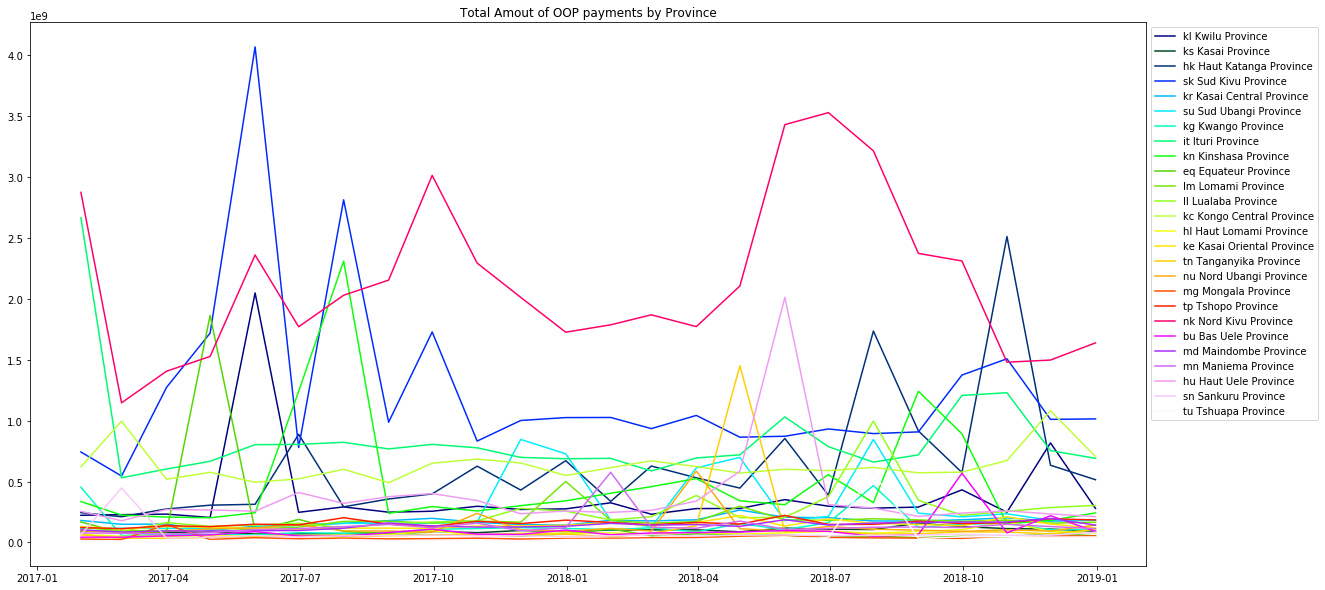

In [8]:
evolution_payments = financial_data_complete.groupby(["uidlevel2", "enddate", "dataelementname"]).value.sum().reset_index()
evolution_payments = evolution_payments.merge(snis.orgunitstructure[["uidlevel2","namelevel2"]], left_on="uidlevel2", right_on="uidlevel2")

dat = evolution_payments[evolution_payments.dataelementname.str.contains("paiement direct")]
plt.figure(figsize=(20,10))
cmap = plt.cm.gist_ncar(np.linspace(0, 1, dat.name.nunique()))
i = 0
for province in dat.name.unique():
    datp=dat[dat.name == province]
    datp.enddate = pd.to_datetime(datp.enddate)
    plt.plot(datp.enddate, datp.value, label = province, c = cmap[i])
    plt.legend(bbox_to_anchor = [1,1])
    i = i + 1
plt.title("Total Amout of OOP payments by Province")

Text(0.5, 1.0, 'Average per-FOSA amount of OOP payment')

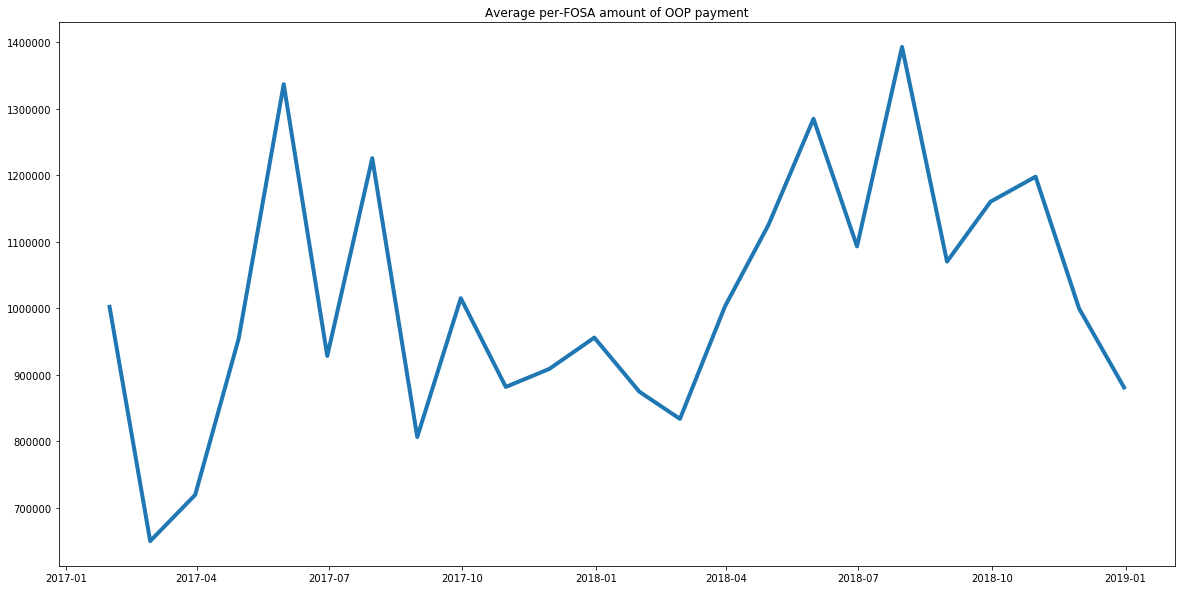

In [9]:
payments_fosa = financial_data_complete[financial_data_complete.dataelementname.str.contains("paiement direct")]

nat = payments_fosa.groupby("enddate").apply(lambda x: x.value.sum() / len(x.uidorgunit.unique())).reset_index()
nat.enddate = pd.to_datetime(nat.enddate)
nat.columns = ["enddate", "value"]

plt.figure(figsize=(20,10))
plt.plot(nat.enddate, nat.value, linewidth = 4)
plt.title("Average per-FOSA amount of OOP payment")

In [217]:
budget = ["recettes paiement direct", "recettes tiers payant",  "autres recettes", "salaire de l'etat", "autres subsides", "prime de l'etat"]
#
budget_data = financial_data_complete[financial_data_complete.dataelementname.str.contains('|'.join(budget))]

(0, 0.9)

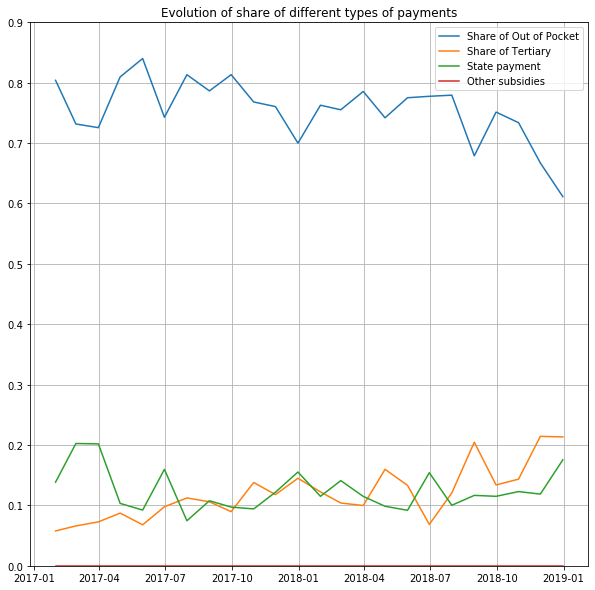

In [219]:
def share_budget(data):
    total = data.value.sum()
    share_oop = (data.value[data.dataelementname.str.contains("recettes paiement direct")].sum() + data.value[data.dataelementname.str.contains("autres recettes")].sum()) / total
    share_tertiary = data.value[data.dataelementname.str.contains("recettes tiers payant")].sum() / total
    state_payment = data.value[data.dataelementname.str.contains("salaire de l'etat|prime de l'etat")].sum() / total
    other_subsidies = data.value[data.dataelementname.str.contains("autres subsides")].sum() / total
    return pd.DataFrame({'total':[total], "share_oop":[share_oop], "other_subsidies":other_subsidies, 
                         "share_tertiary":[share_tertiary], "state_payment":state_payment})

evol_budget = budget_data.groupby("enddate").apply(share_budget).reset_index()

plt.figure(figsize= (10,10))
plt.plot(evol_budget.enddate, evol_budget.share_oop, label = "Share of Out of Pocket")
plt.plot(evol_budget.enddate, evol_budget.share_tertiary, label = "Share of Tertiary")
plt.plot(evol_budget.enddate, evol_budget.state_payment, label = "State payment")
plt.plot(evol_budget.enddate, evol_budget.other_subsidies, label = "Other subsidies")
plt.legend(bbox_to_anchor = [1,1])
plt.legend(bbox_to_anchor = [1,1])
plt.title("Evolution of share of different types of payments")
plt.yticks(np.arange(0, 1, step=0.1))
plt.grid()
plt.ylim((0,.9))

(0, 0.9)

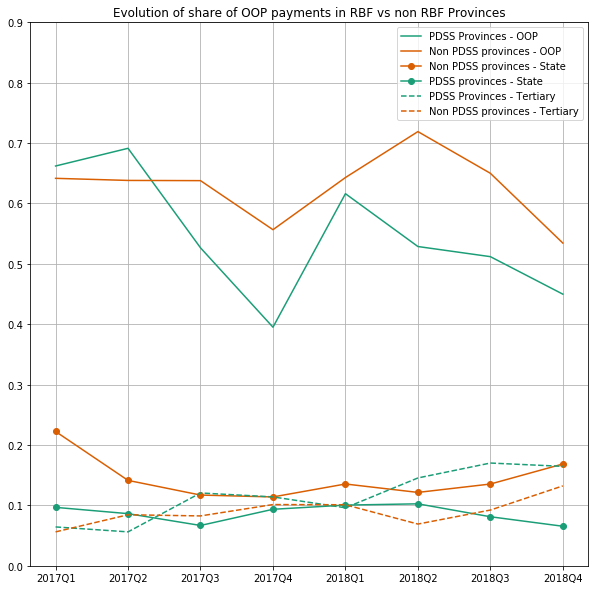

In [177]:
share_province = budget_data.groupby(["enddate", "uidlevel2"]).apply(share_budget).reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")
pdss_provinces = share_province.uidlevel2[share_province.name.str.contains('|'.join(["eq ","hk ","hl ","ll ","mg ", "mn ","sk ", "nk ", "su ", "tu ", "kg ", "kl "]))].unique().tolist()

pdss_budget = budget_data[(budget_data.uidlevel2.isin(pdss_provinces)) & (budget_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist()))]
non_pdss_budget = budget_data[~ budget_data.uidlevel2.isin(pdss_provinces)& ~(budget_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist()))]

pdss_share = pdss_budget.groupby(["quarterly"]).apply(share_budget).reset_index()
non_pdss_share = non_pdss_budget.groupby(["quarterly"]).apply(share_budget).reset_index()

cmap = mpl.cm.get_cmap('Dark2')
plt.figure(figsize= (10,10))
plt.plot(pdss_share.quarterly, pdss_share.share_oop, label = "PDSS Provinces - OOP", c=cmap(0))
plt.plot(non_pdss_share.quarterly, non_pdss_share.share_oop, label = "Non PDSS provinces - OOP", c=cmap(1))
plt.plot(non_pdss_share.quarterly, non_pdss_share.state_payment, "o-",label = "Non PDSS provinces - State", c=cmap(1))
plt.plot(pdss_share.quarterly, pdss_share.state_payment, "o-" ,label = "PDSS provinces - State", c=cmap(0))
plt.plot(pdss_share.quarterly, pdss_share.share_tertiary, "--", c=cmap(0), label = "PDSS Provinces - Tertiary")
plt.plot(non_pdss_share.quarterly, non_pdss_share.share_tertiary, "--", c=cmap(1), label = "Non PDSS provinces - Tertiary")
plt.legend(bbox_to_anchor = [1,1])
plt.title("Evolution of share of OOP payments in RBF vs non RBF Provinces")
plt.yticks(np.arange(0, 1, step=0.1))
plt.grid()
plt.ylim((0,.9))

Additional we need to tailor this to PDSS interevention FOSAs

Data we need : 
    Where single contract is happening
    Date entry in PDSS
    
% FOSAs in PDSS by province

In [85]:
snis_fosa = snis_extract.groupby("uidlevel2").uidorgunit.apply(lambda x : x.nunique()).reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")
pdss_fosa = pdss_extract.groupby("uidlevel2").uidorgunit.apply(lambda x : x.nunique()).reset_index().merge(pdss.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")

In [94]:
snis_fosa.name = snis_fosa.name.str.lower()
pdss_fosa.name = pdss_fosa.name.str.lower()
pdss_fosa.name = pdss_fosa.name.str.replace("dps", "province")

In [99]:
snis_pdss_compare = snis_fosa.merge(pdss_fosa, on = "name" , suffixes = ["_snis", "_pdss"]).set_index("name")

In [102]:
snis_pdss_compare.uidorgunit_pdss / snis_pdss_compare.uidorgunit_snis

name
kl kwilu province            0.287953
hk haut katanga province     0.102444
sk sud kivu province         0.171371
su sud ubangi province       0.310256
kg kwango province           0.311927
eq equateur province         0.289179
kc kongo central province    0.000725
hl haut lomami province      0.460573
mg mongala province          0.418426
nk nord kivu province        0.118240
md maindombe province        0.352273
tu tshuapa province          0.432184
dtype: float64

In [ ]:
variables_dict = {"consultation prénatale 4ème visite - ver":"ANC4", "a 2.1 cpn 4":"ANC4",
                  "consultation prénatale 1ère visite - ver":"ANC1", "a 2.1 cpn 1":"ANC1",
                  "paludisme simple confirmé":"confirmed_malaria", "Paludisme simple confirmé traité \(PN\)":"treated_malaria",
                  "consultation postnatale - ver":"PNC", 
                  "enfant complètement vacciné - ver":"fully_immunized_children",
                  "accouchement assisté - ver":"assisted_delivery", "a 2.3 accouchements par personnel qualifié":"assisted_delivery"}

In [151]:
pdss_anc_4 = pdss_extract[pdss_extract.dataelementname == "consultation prénatale 4ème visite - ver"]
pdss_provinces = share_province.uidlevel2[share_province.name.str.contains('|'.join(["eq ","hk ","hl ","ll ","mg ", "mn ","sk ", "nk ", "su ", "tu ", "kg ", "kl "]))].unique().tolist()
snis_pdss = snis_extract[(snis_extract.uidlevel2.isin(pdss_provinces))]

In [164]:
def make_counterfactual(snis_indicator, snis_pdss=snis_pdss, pdss_extract=pdss_extract,  pdss_indcator= None):
    snis_data = snis_pdss[snis_pdss.dataelementname == snis_indicator]
    snis_pdss_average = snis_data[snis_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist())].groupby("enddate").value.apply(np.mean).reset_index()
    snis_non_pdss_average = snis_data[~ snis_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist())].groupby("enddate").value.apply(np.mean).reset_index()
    ref = snis_non_pdss_average[snis_non_pdss_average.enddate == min(snis_non_pdss_average.enddate)].value.iloc[0]
    counterfactual = snis_pdss_average.value[snis_pdss_average.enddate == min(snis_pdss_average.enddate)].iloc[0] * snis_non_pdss_average.value / ref
    return {"snis_pdss_average":snis_pdss_average, "snis_non_pdss_average":snis_non_pdss_average, "counterfactual":counterfactual}

def make_counterfactual_plot(counterfactual_dic, title):
    plt.figure(figsize = (20, 10))
    counterfactual_dic["snis_pdss_average"].enddate
    plt.plot(counterfactual_dic["snis_pdss_average"].enddate, counterfactual_dic["snis_pdss_average"].value, 
                 label = "pdss")
    plt.plot(counterfactual_dic["snis_non_pdss_average"].enddate, counterfactual_dic["snis_non_pdss_average"].value, 
                 label = "non - pdss")
    plt.plot(counterfactual_dic["snis_non_pdss_average"].enddate, counterfactual_dic["counterfactual"], 
                 label = "pdss counterfactual")
    plt.ylim(0)
    plt.legend(bbox_to_anchor = (1,1))
    plt.title(title)

a 2.1 cpn 1
a 2.1 cpn 4
a 2.1 cpn 4 à la 36ème semaine
a 1.4 cas suspect
a 1.4 tdr réalisé
a 1.4 paludisme simple confirmé
a 2.3 accouchées référées l'hgr
a 1.5 paludisme simple confirmé fe
a 1.5 paludisme simple confirmé traité selon pn-fe
a 1.5 paludisme grave fe
a 3.1 nouvelle acceptante pf (total)
a 2.3 accouchements
a 2.3 accouchements par personnel qualifié
a 2.1 femmes enc. avec pb < 230mm
a 1.5 paludisme grave traité fe
a 2.5 décès maternels dans la communauté
a 1.4 paludisme présumé
a 1.4 paludisme grave traité
a 1.4 tdr positif
a 2.1 cpn 1 à la 16ème semaine
a 2.1 cpn 3


/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


a 2.4 décès nouveaux nés ≤ 7 jours
a 2.5 accouchements dans la communauté
a 2.6 cpon1 (6ème heure)
a 2.6 cpon3 (42ème jour)
a 1.4 paludisme grave
a 1.4 paludisme simple confirmé traité [pn]
a 2.1 femmes enc. à risque détectées
a 2.4 décès nouveaux nés ≤ 28 jours
a 2.4 décès maternels
a 2.4 décès maternels revus
a 2.1 cpn 2
a 2.6 cpon2 (6ème jour)
a 1.4 paludisme présumé traité
b 7.1 dont accouchées référées
b 7.2 paludisme grave - décès
i.1.1 paludisme simple confirmé traité asaq
i.1.1 paludisme simple confirmé traité asaq avec effet indésirable
i.3.1 tdr positif
i.3.1 tdr réalisé
i.1.1 paludisme simple confirmé traité asaq avec effet indésirable grave
i.1.1 paludisme simple confirmé traité al avec effet indésirable grave
i.1.1 paludisme simple confirmé traité al 
i.1.1 paludisme simple confirmé traité al avec effet indésirable
o dispo accouchements (registre des accouchements)
o3 pma accouchements
o pma accouchements
o3 test1 accouchements (registre maternité)


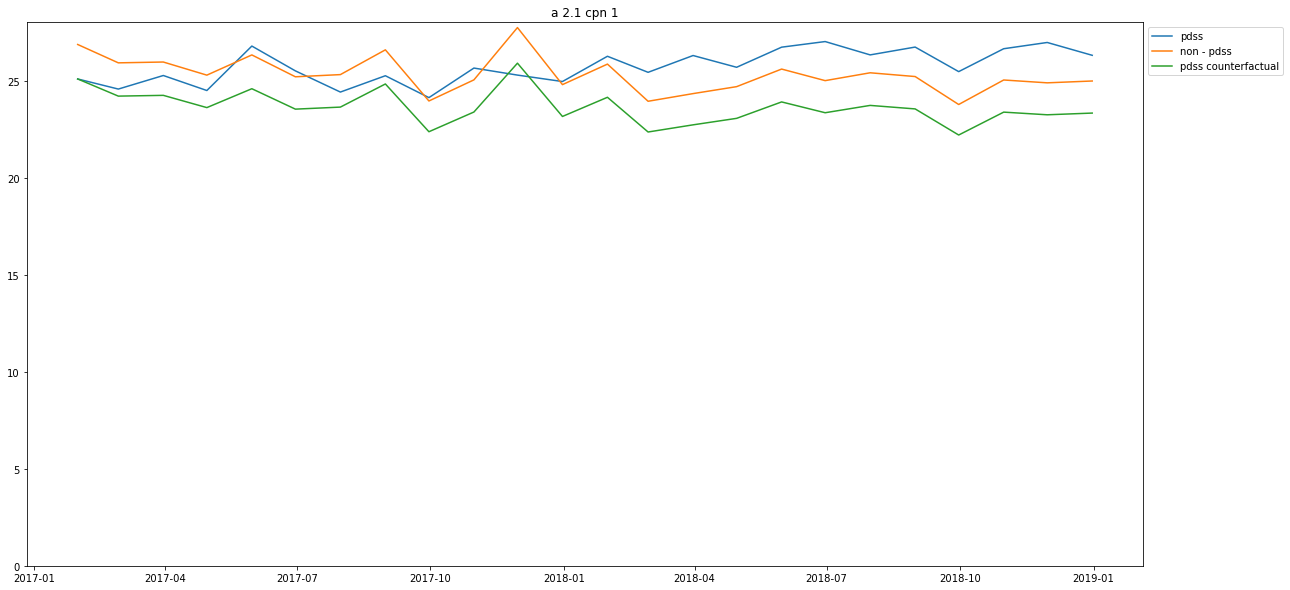

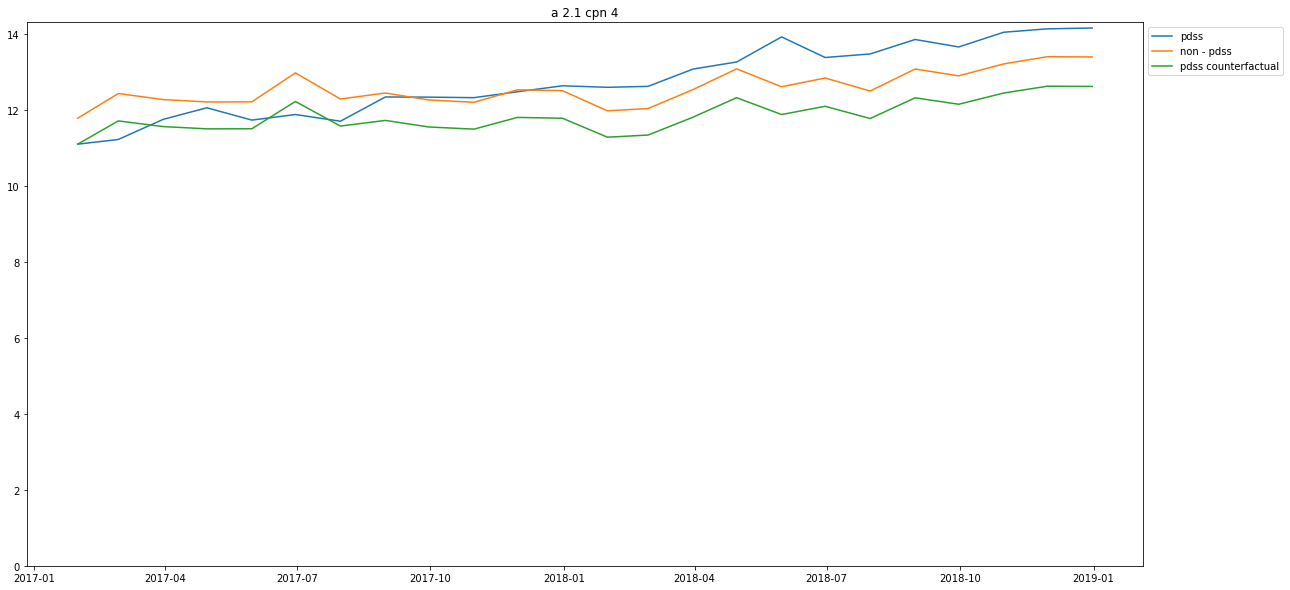

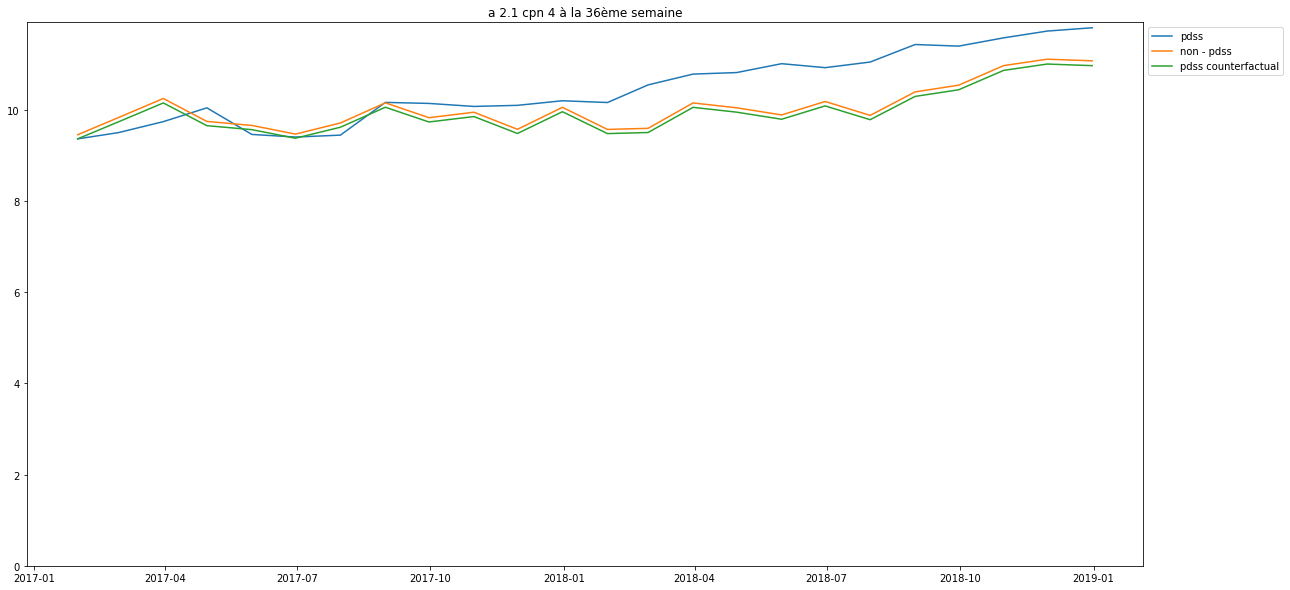

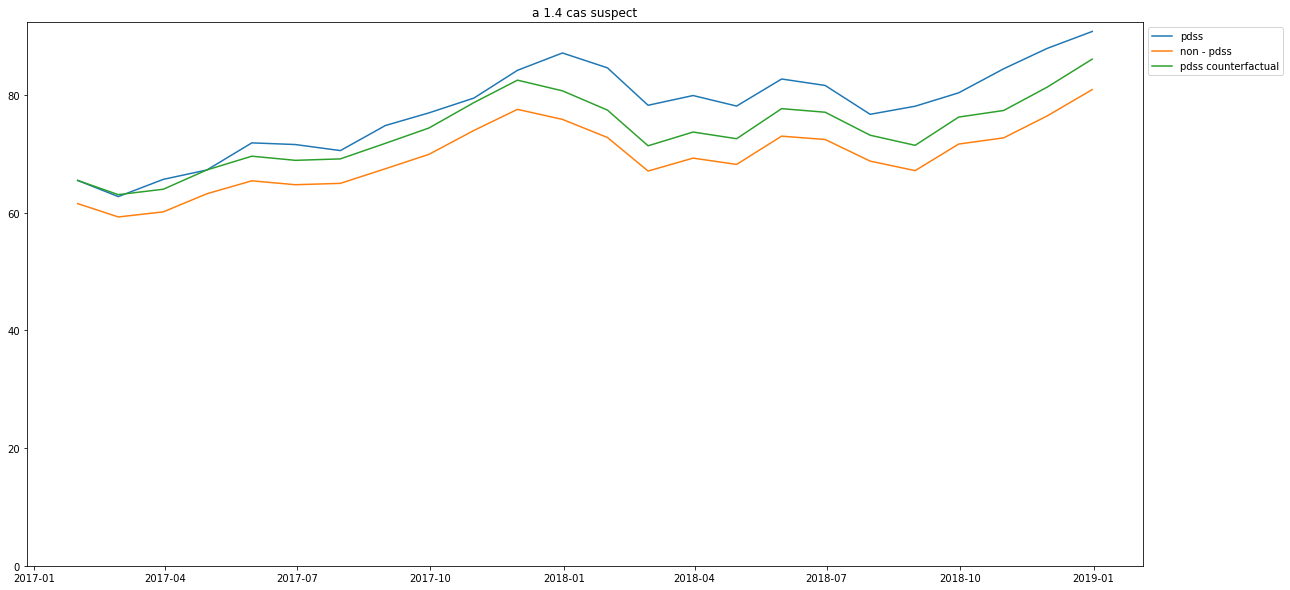

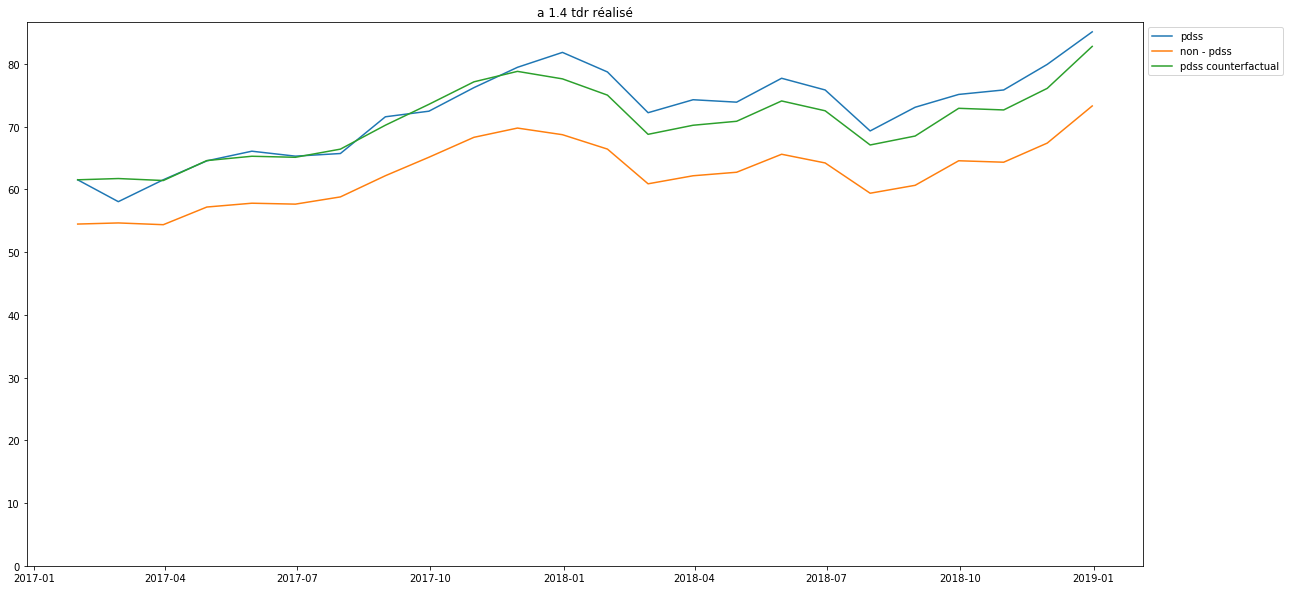

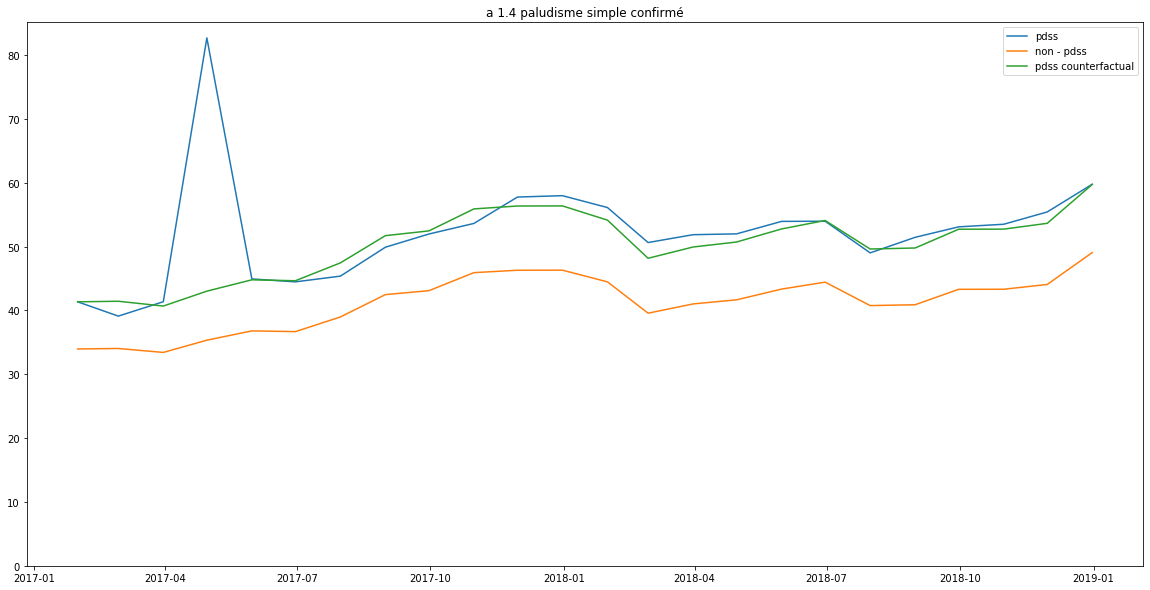

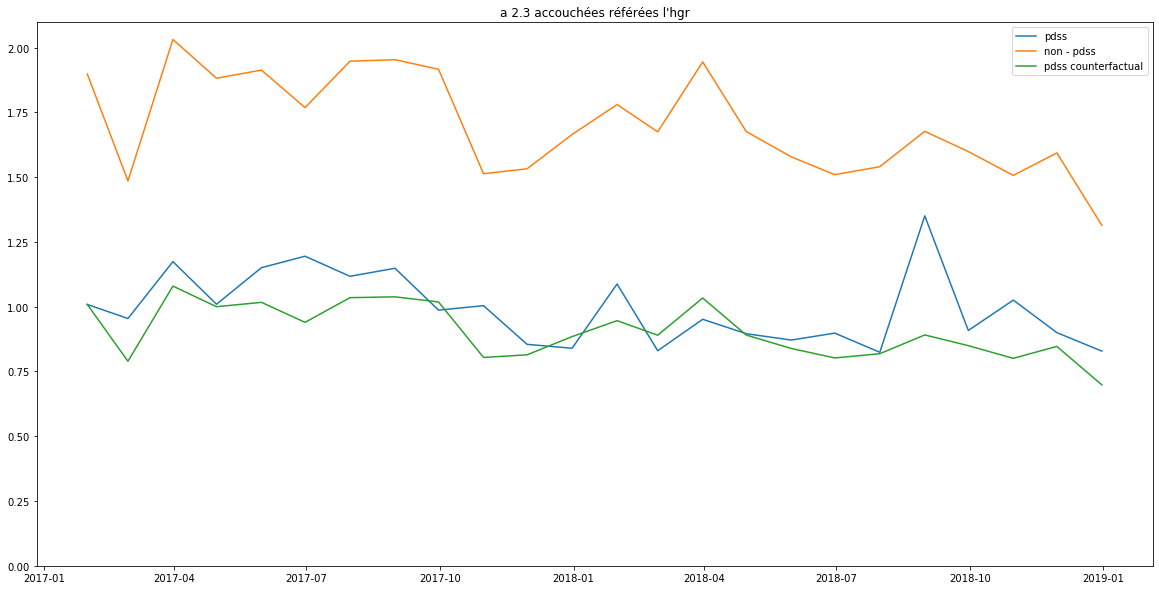

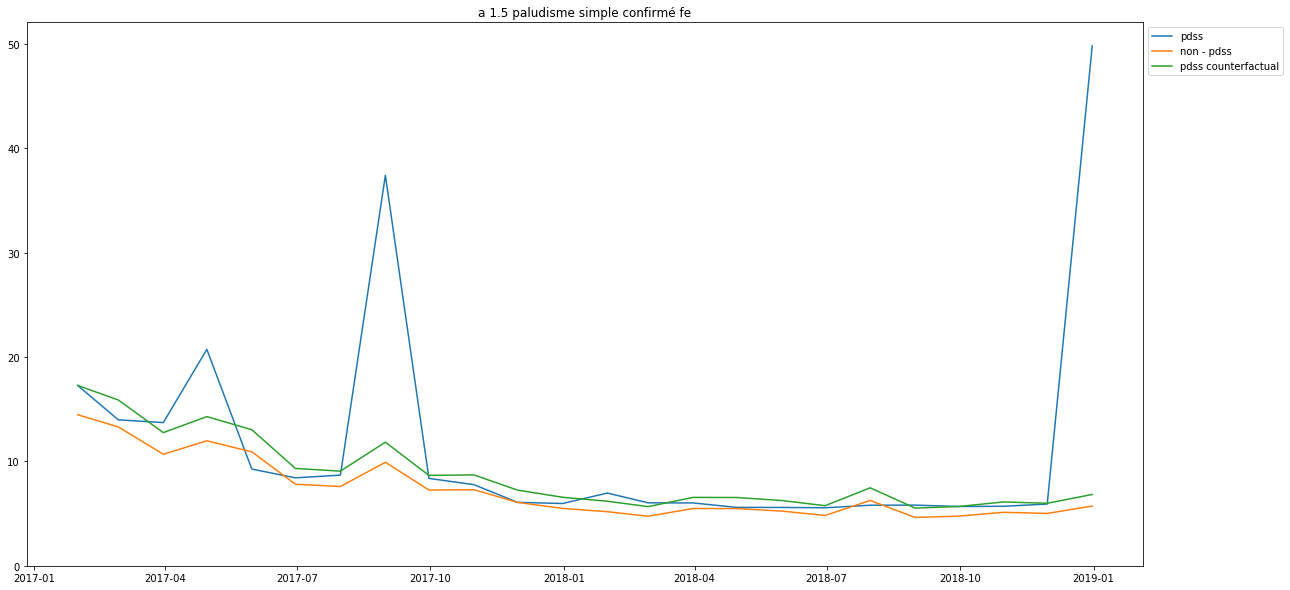

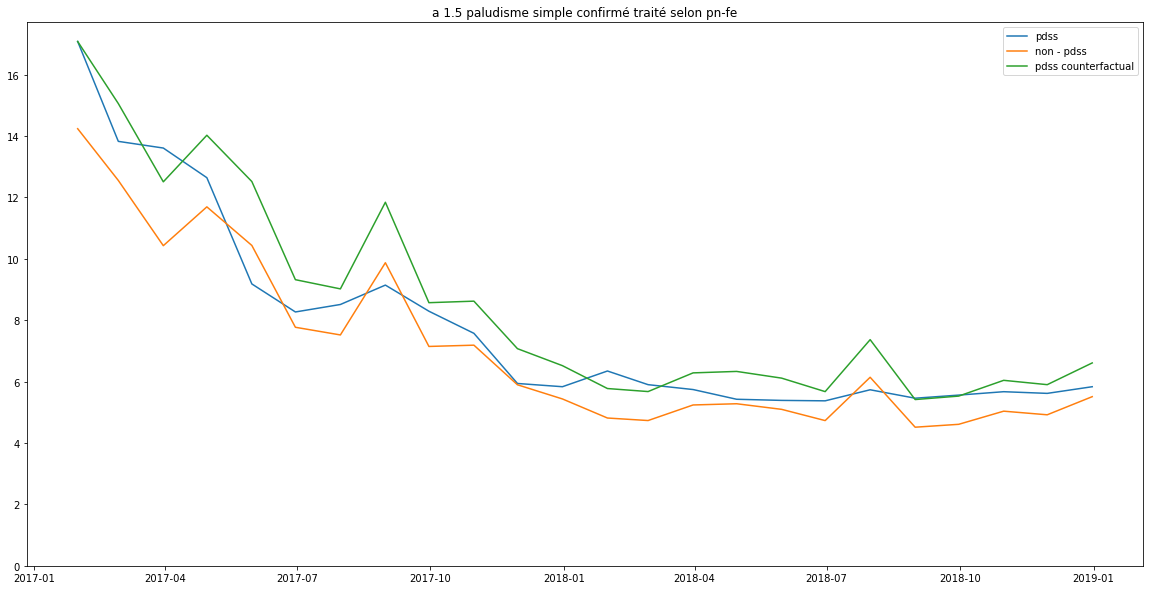

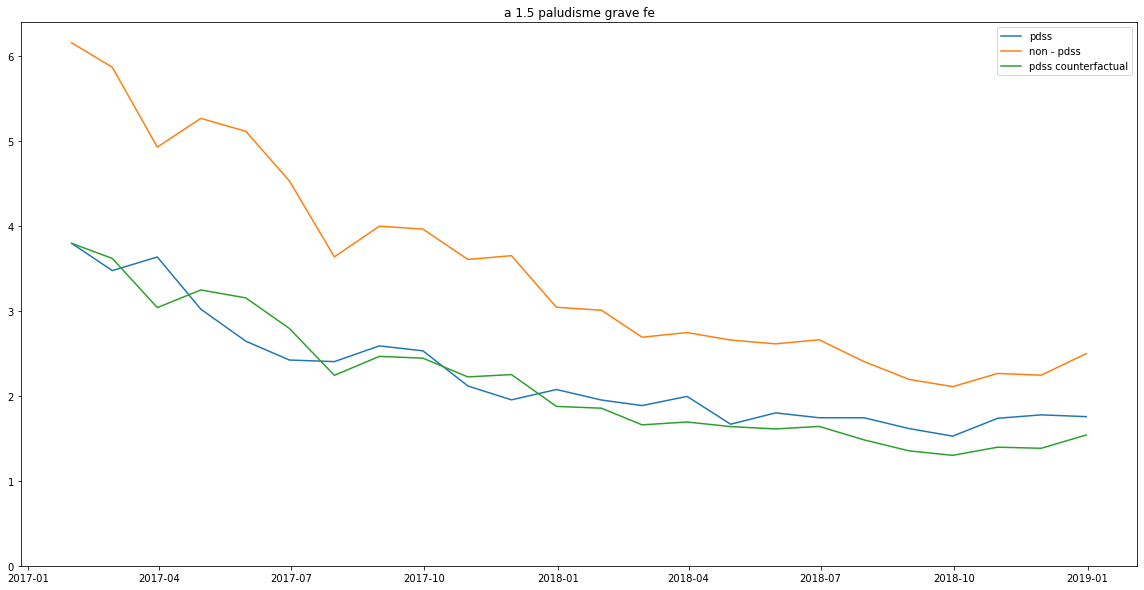

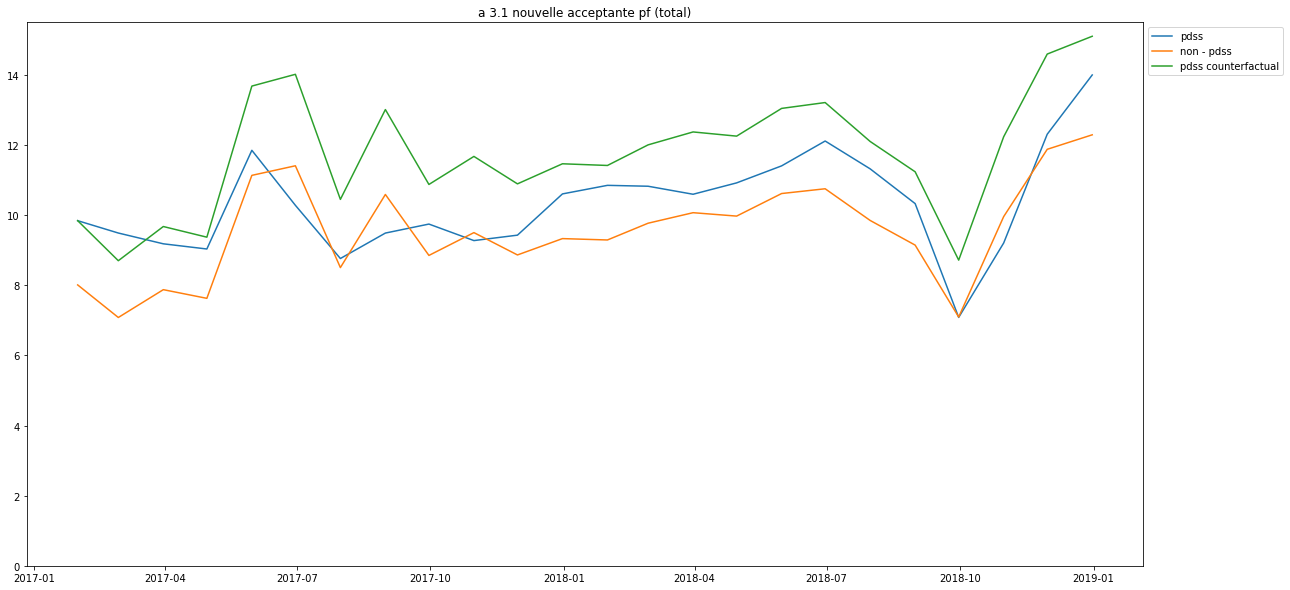

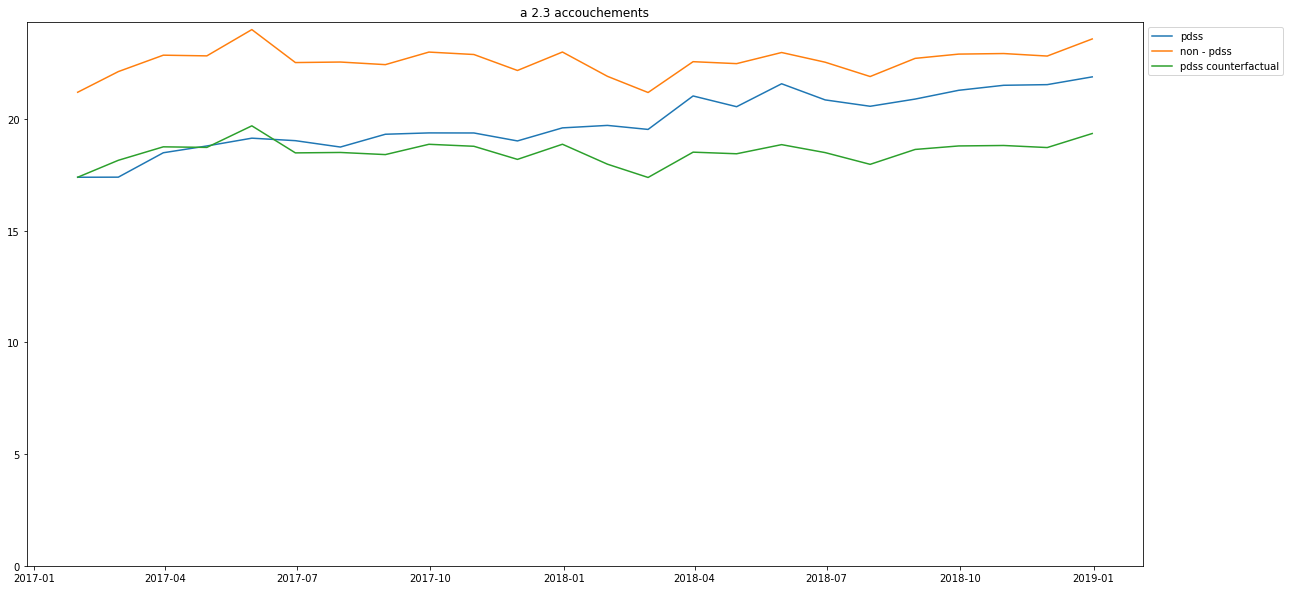

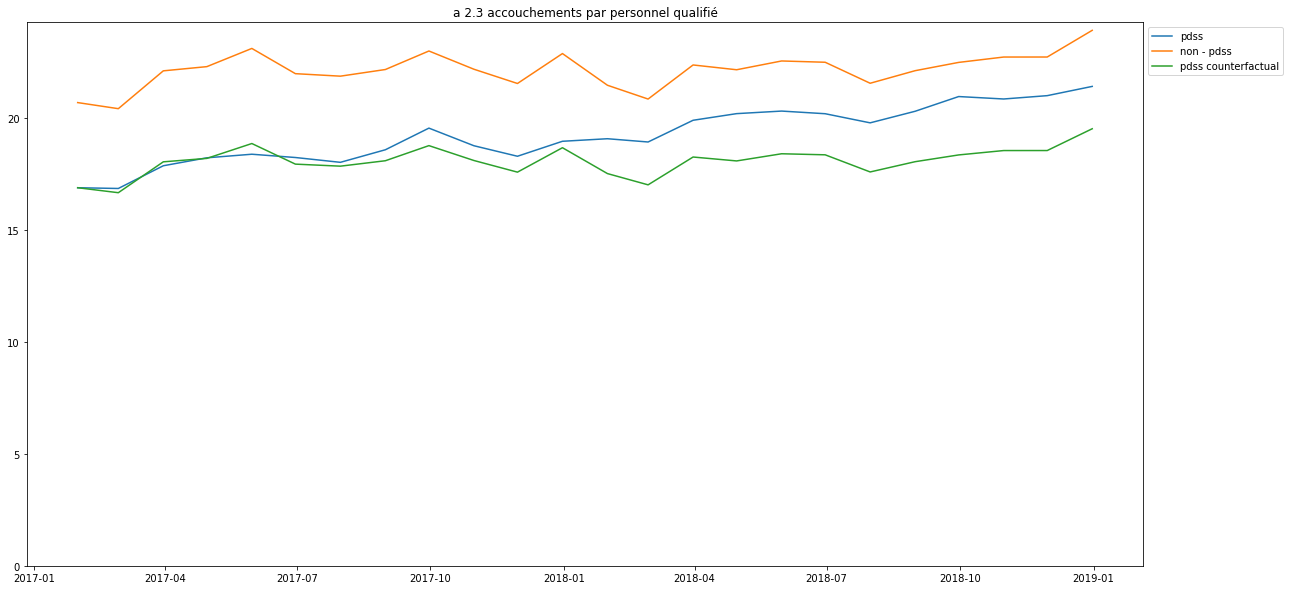

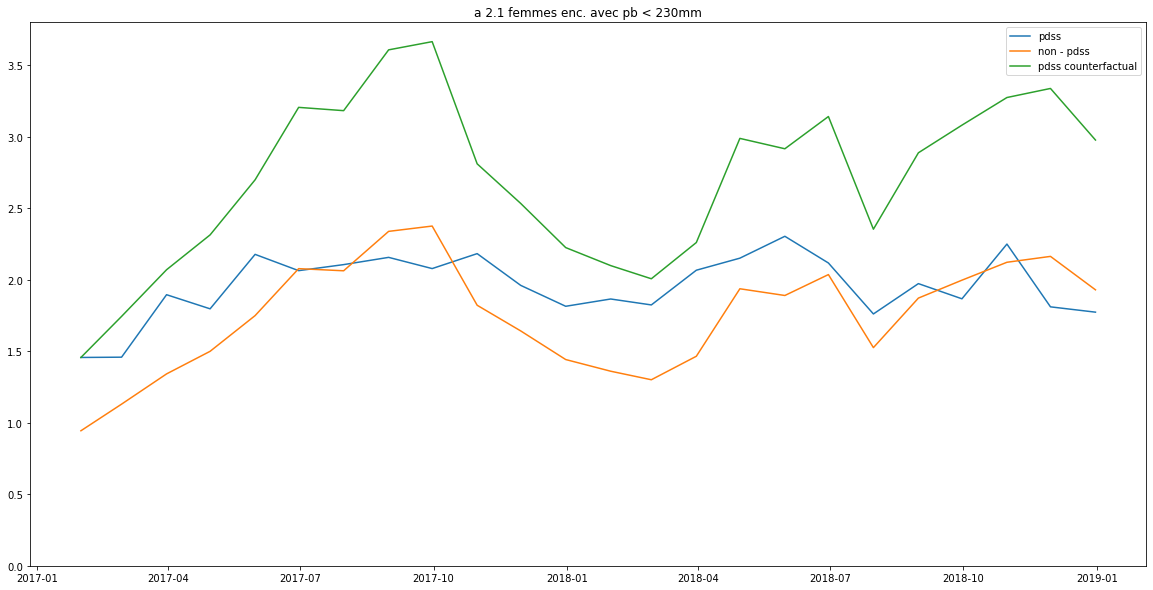

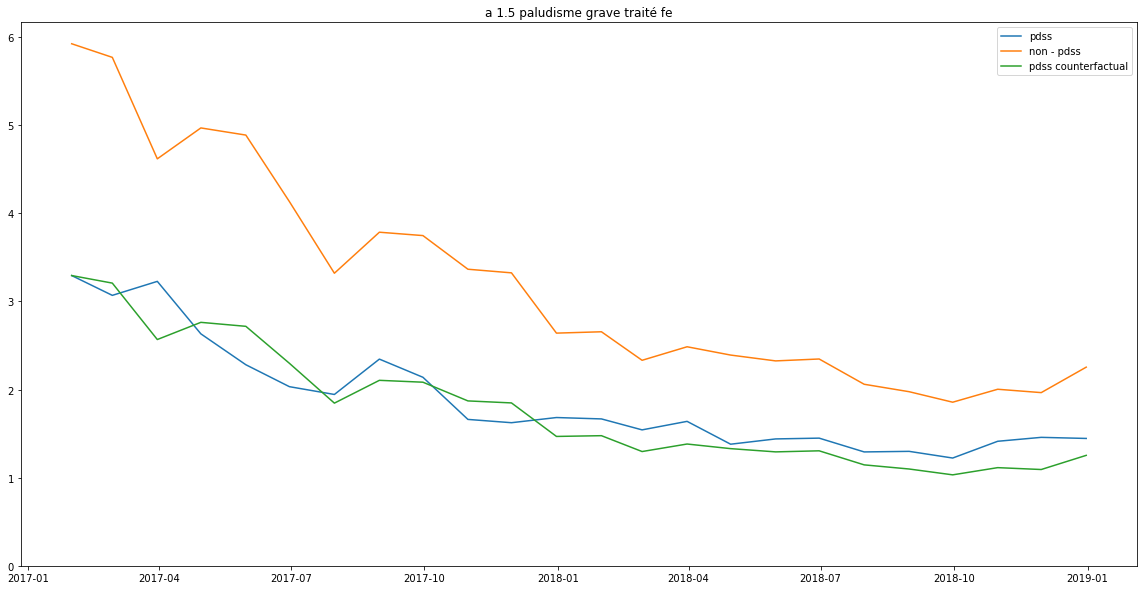

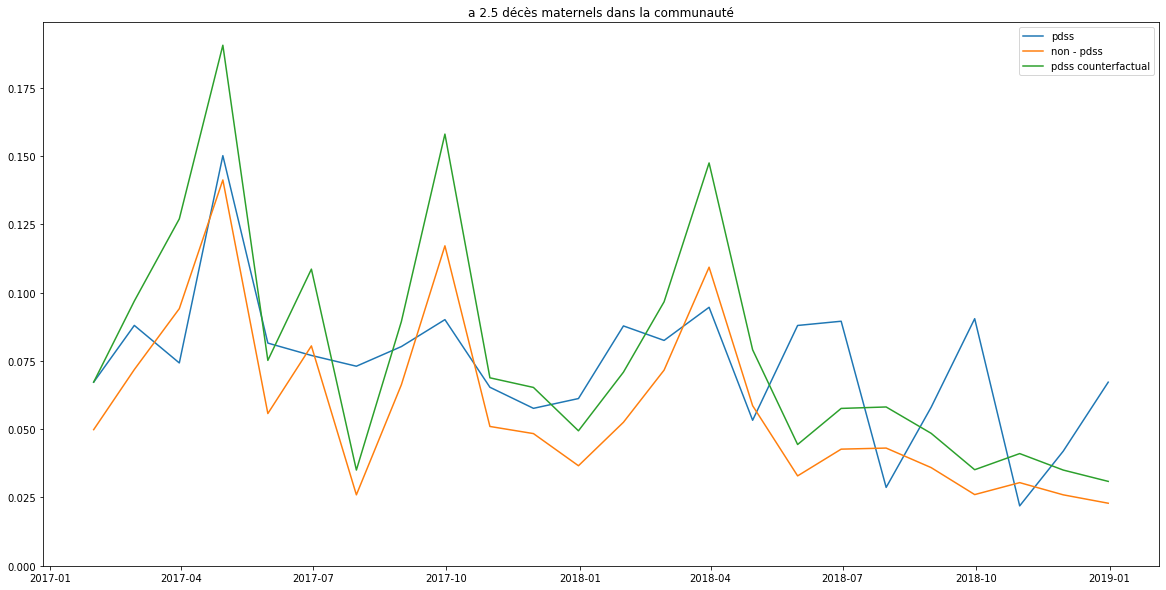

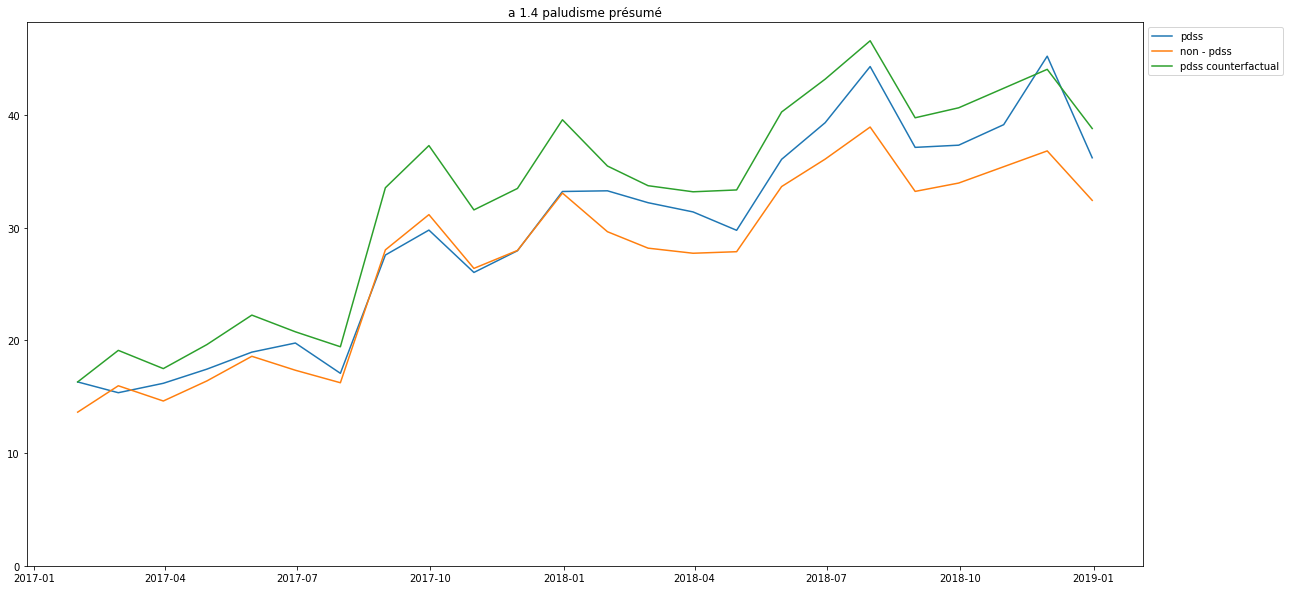

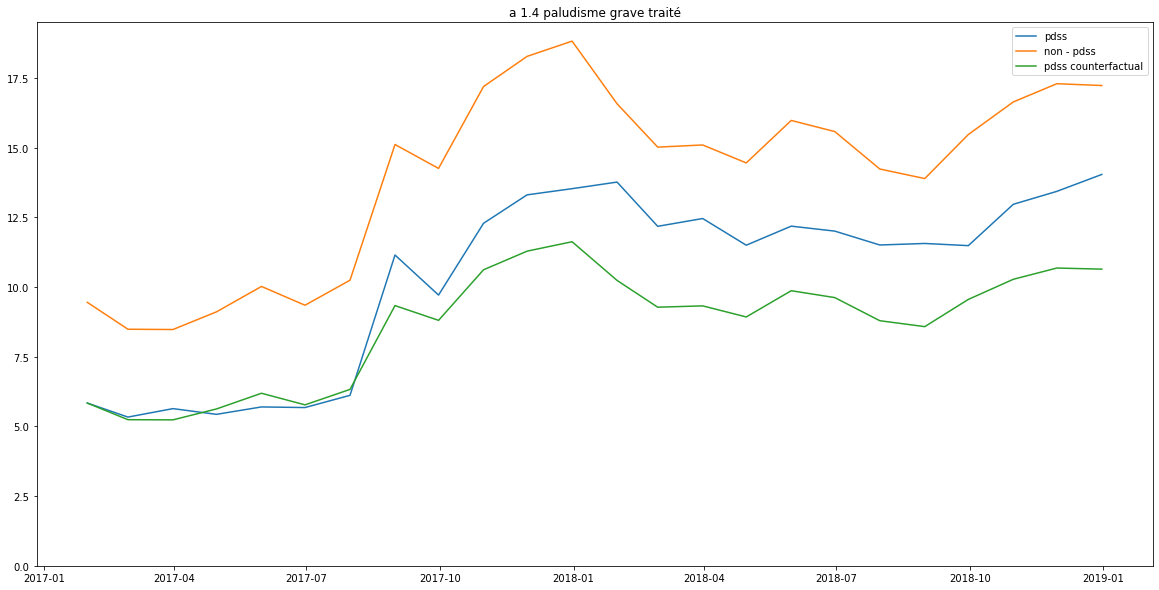

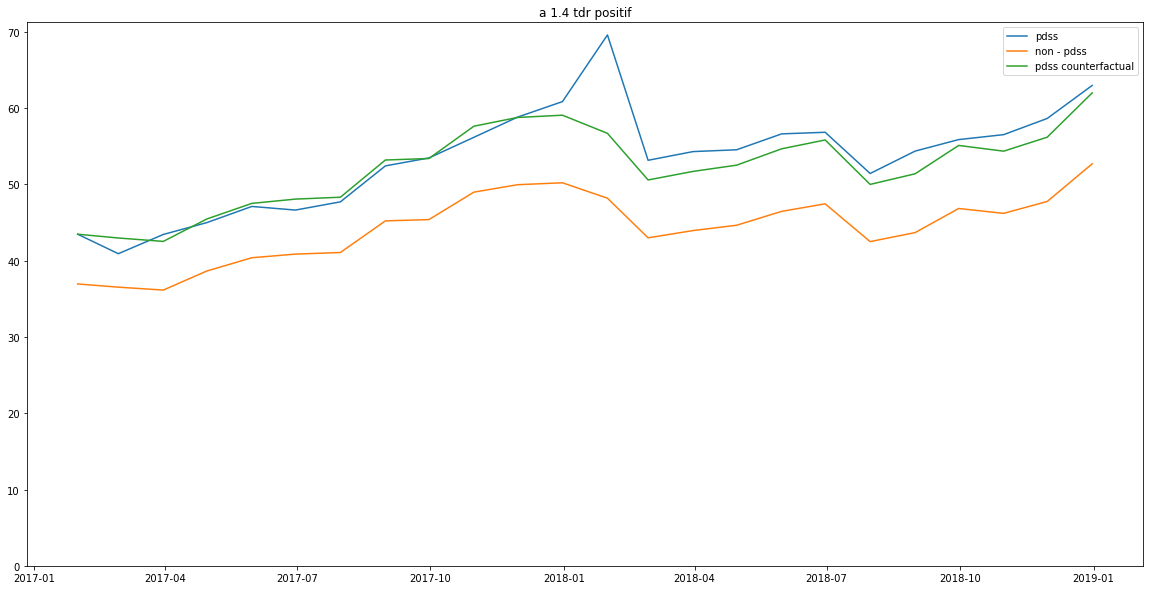

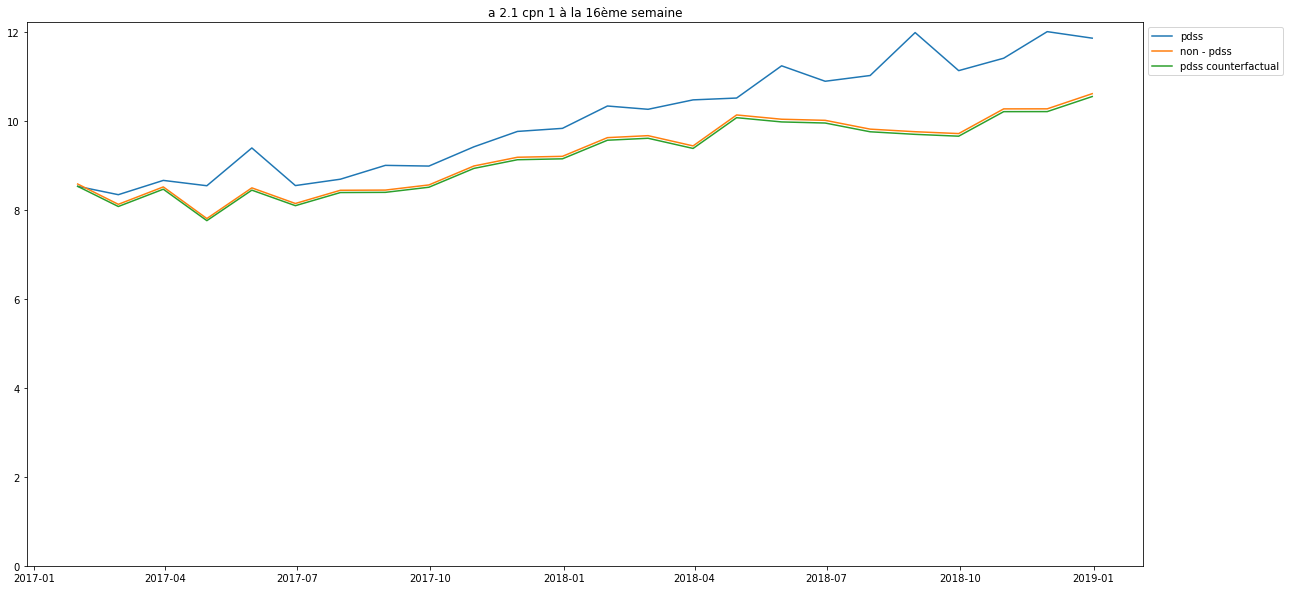

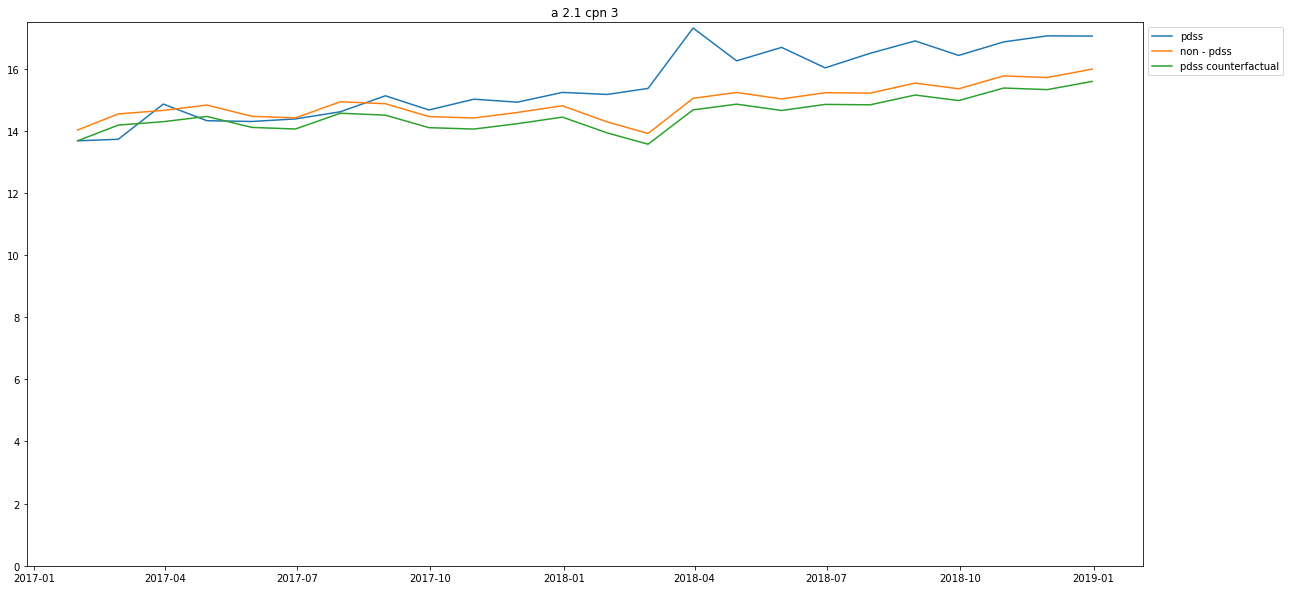

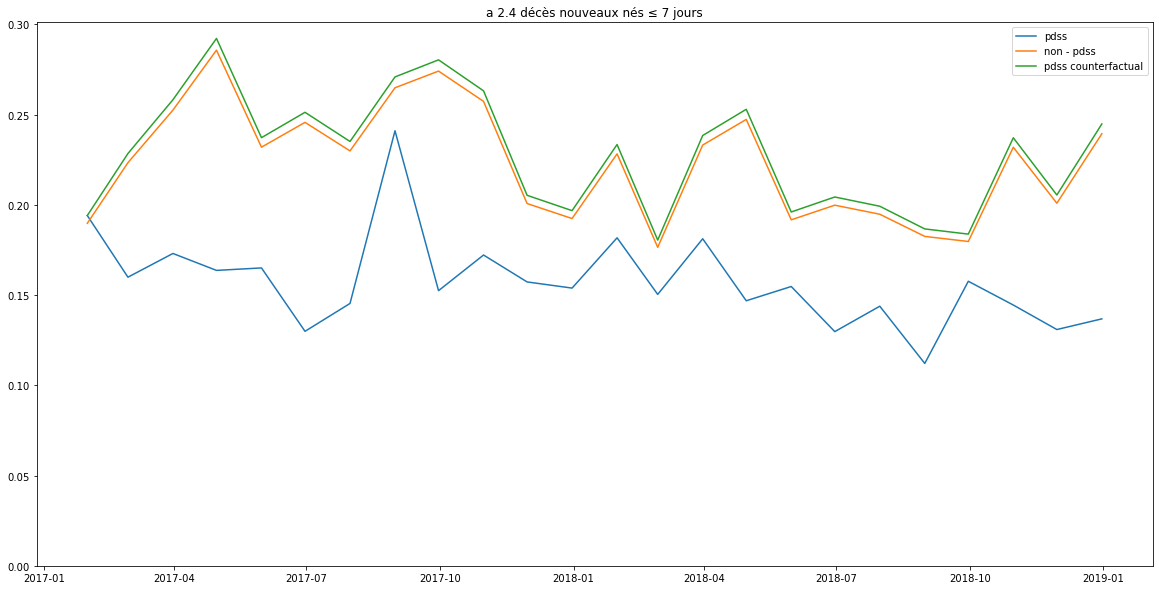

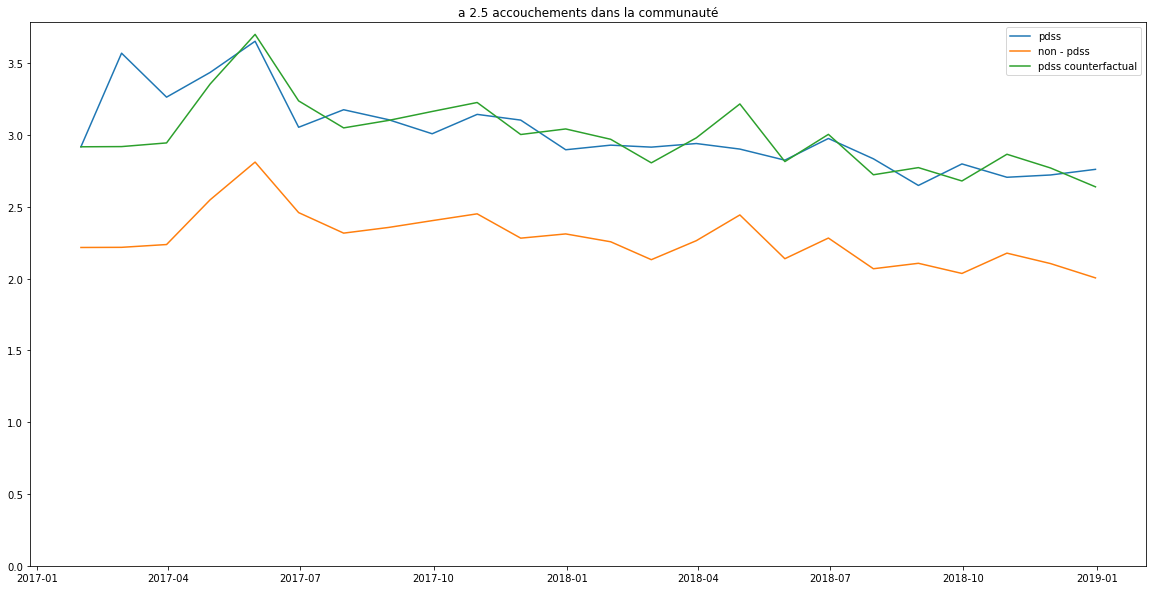

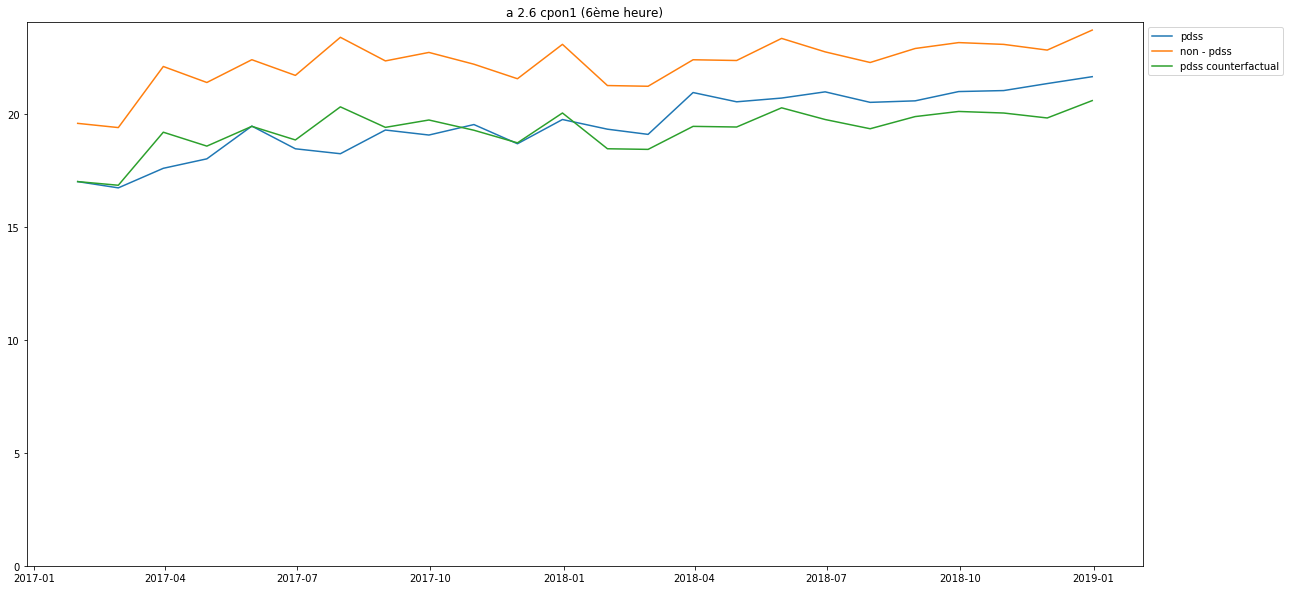

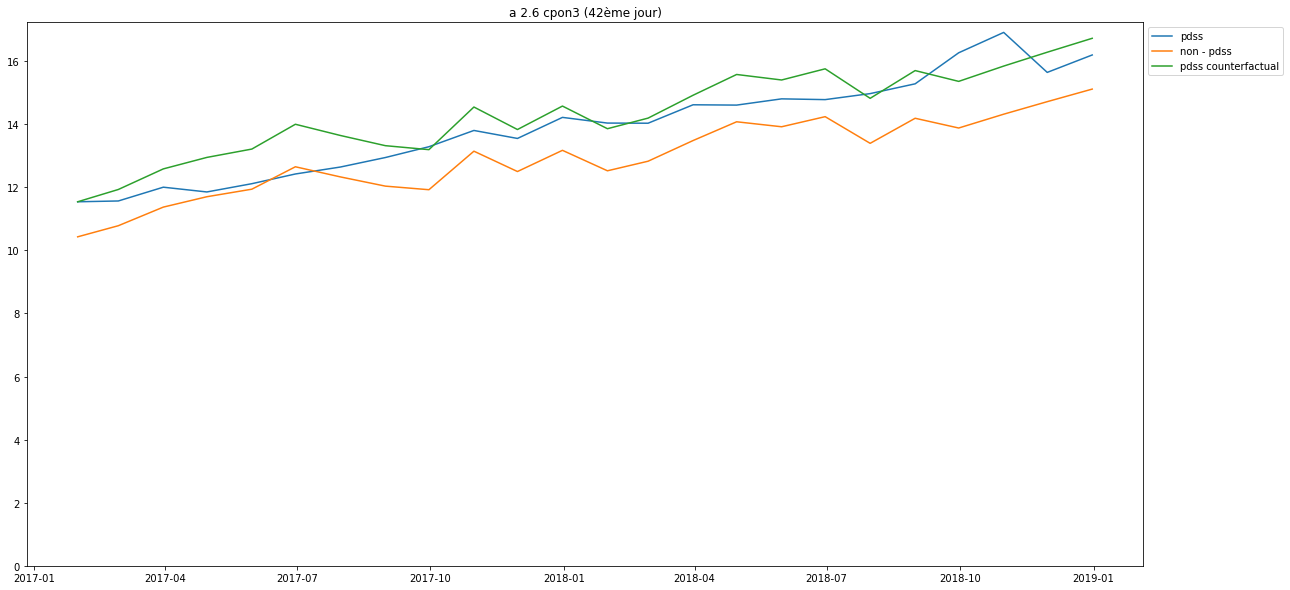

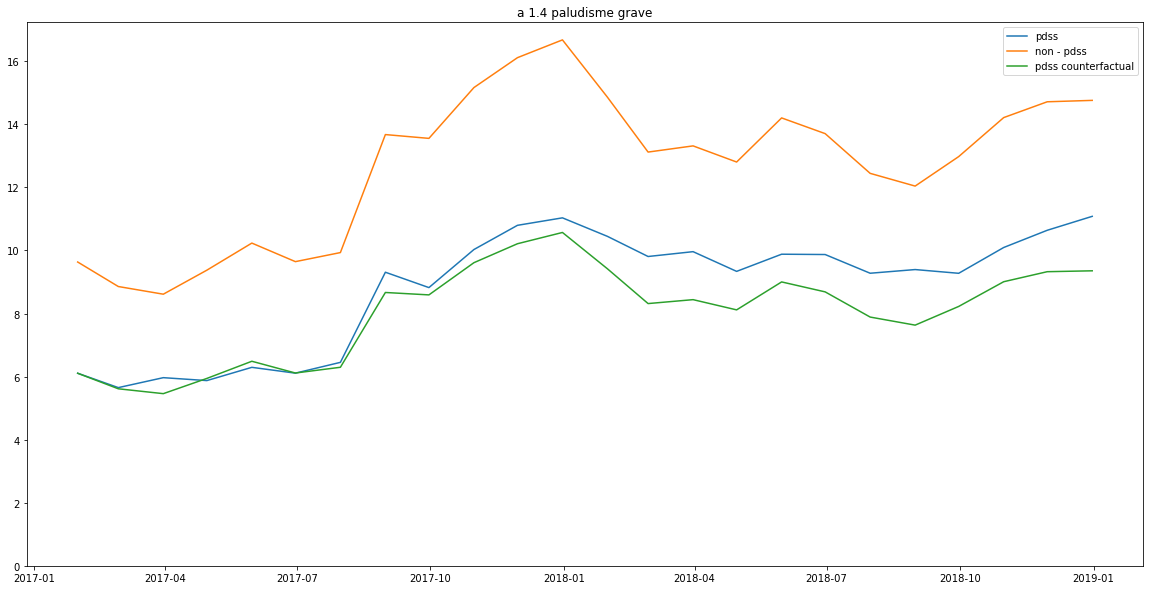

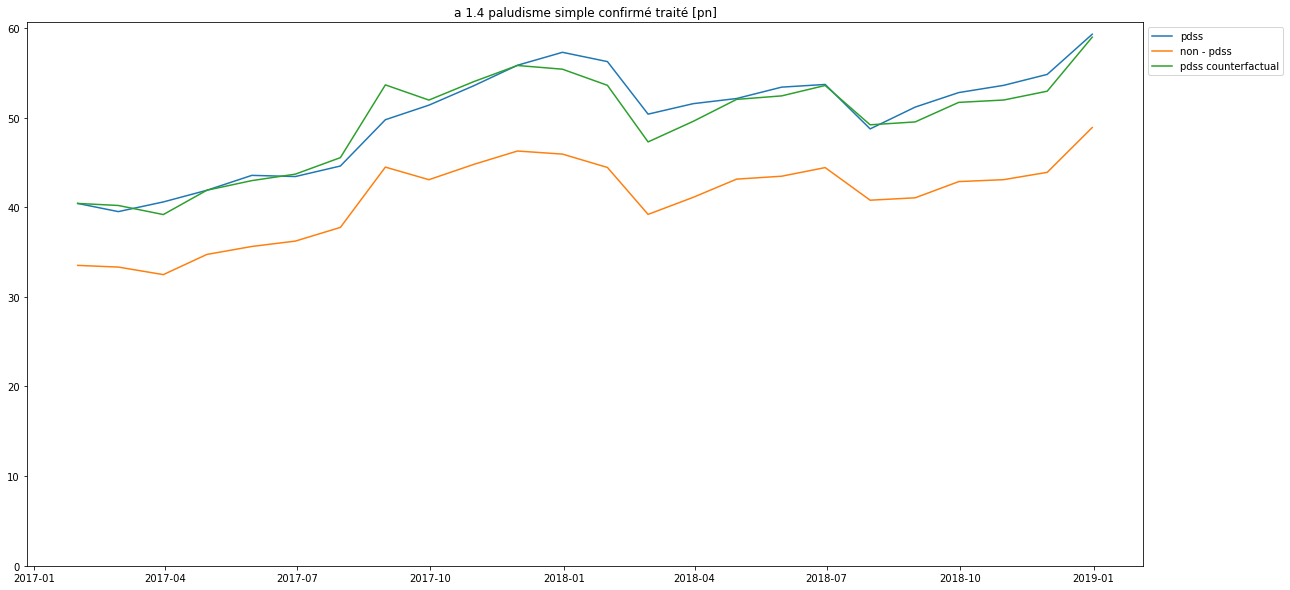

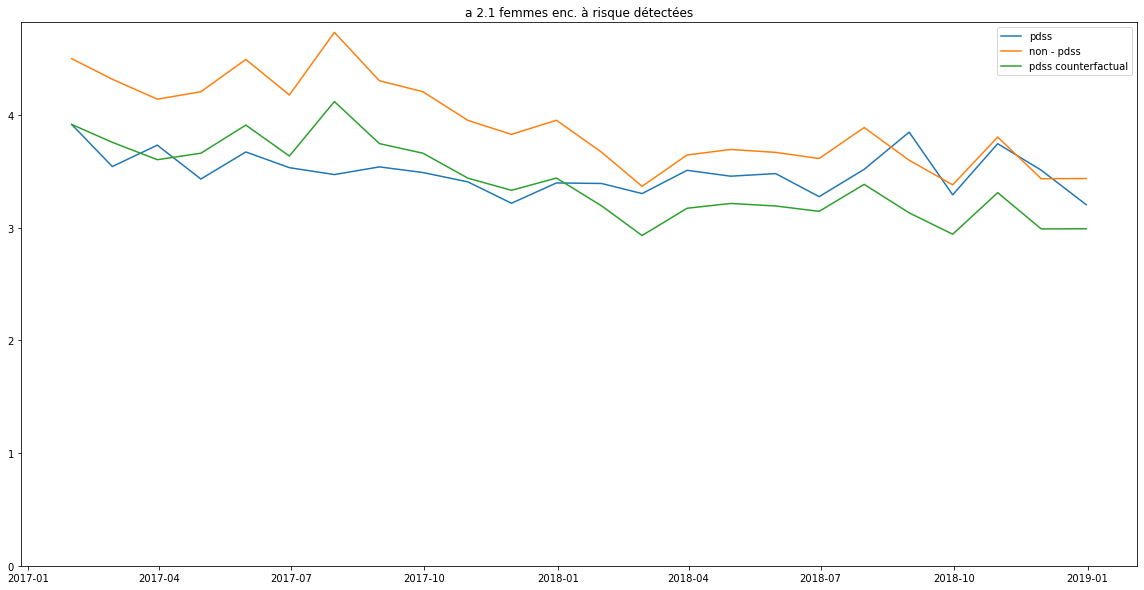

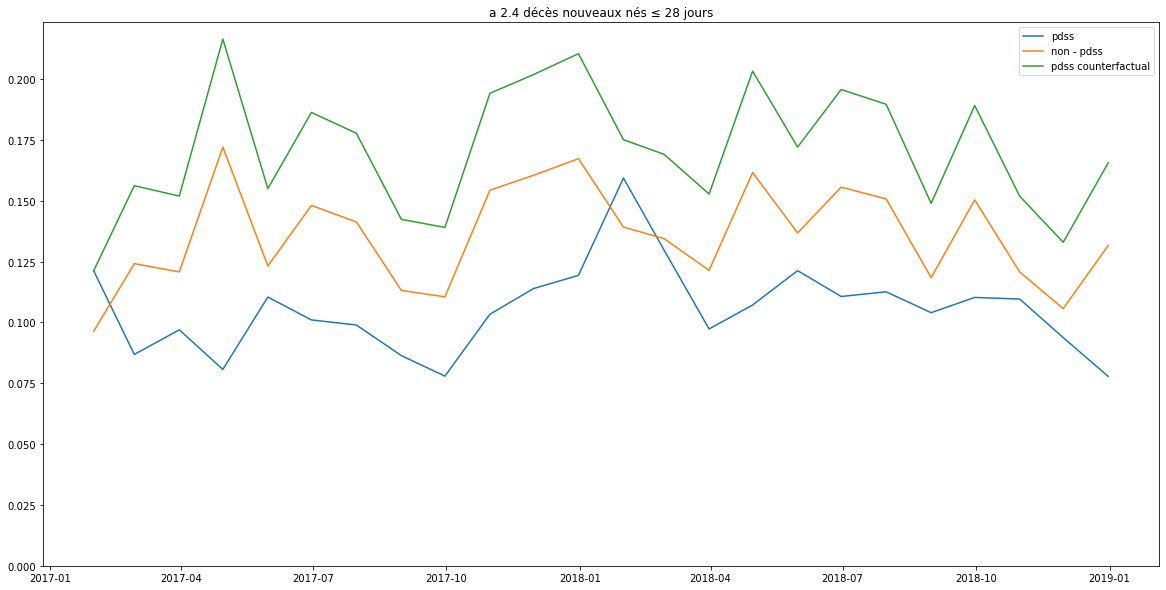

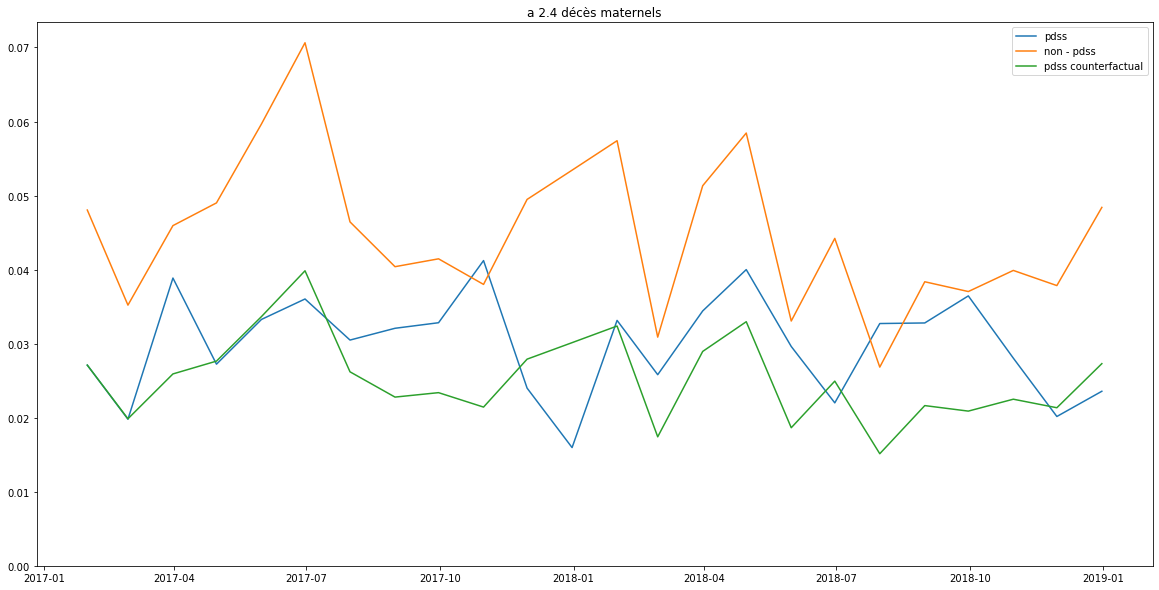

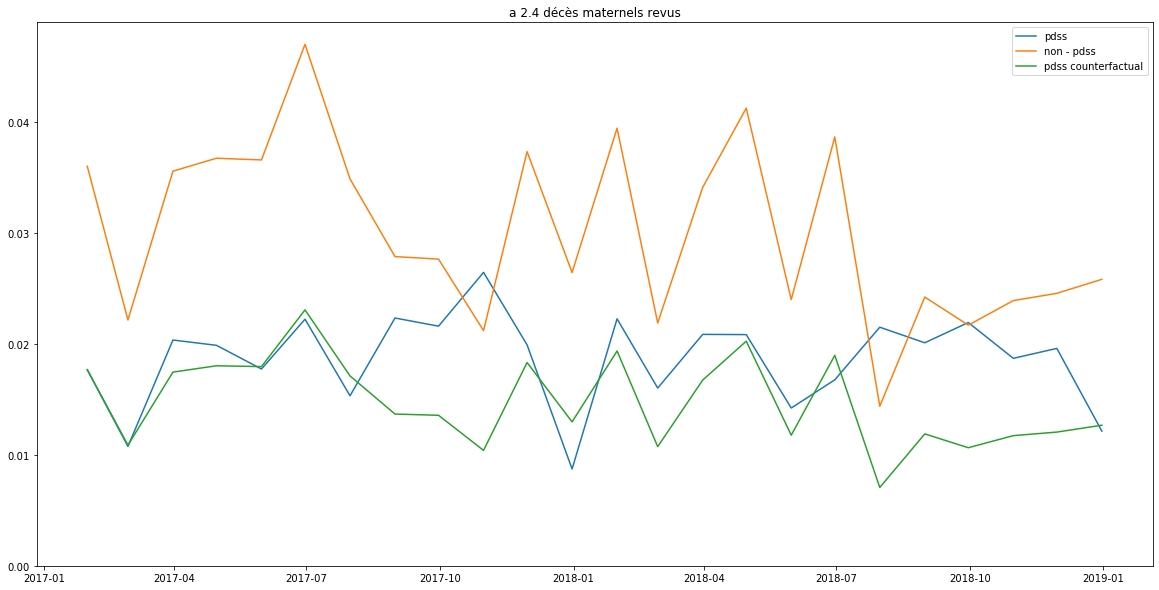

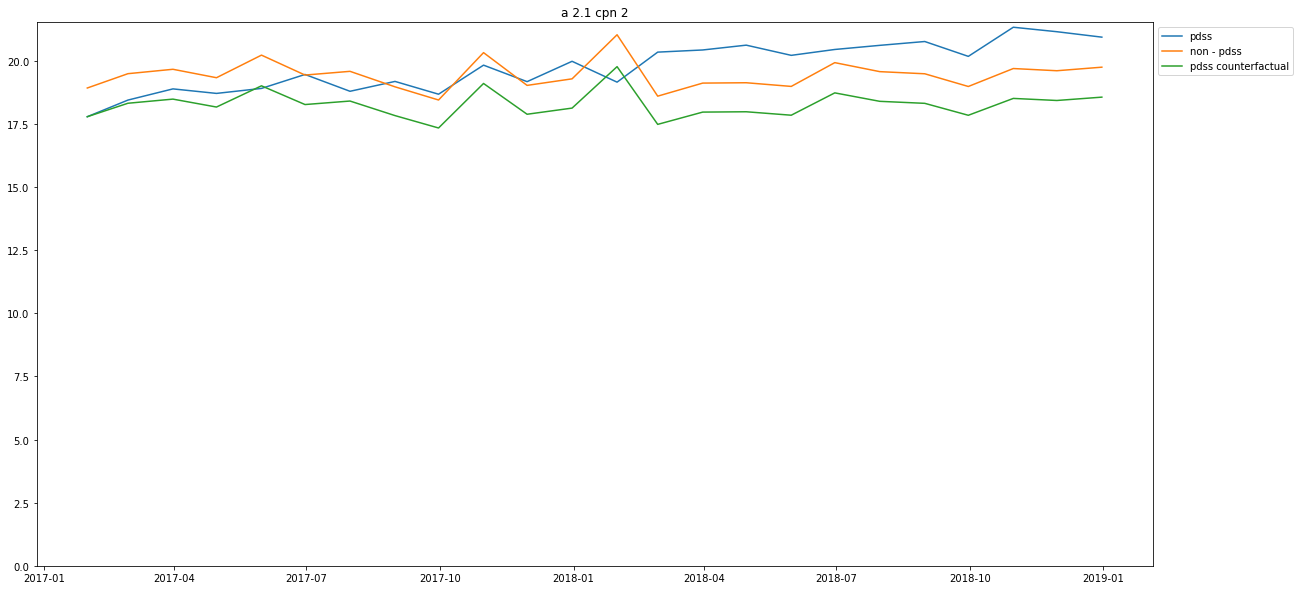

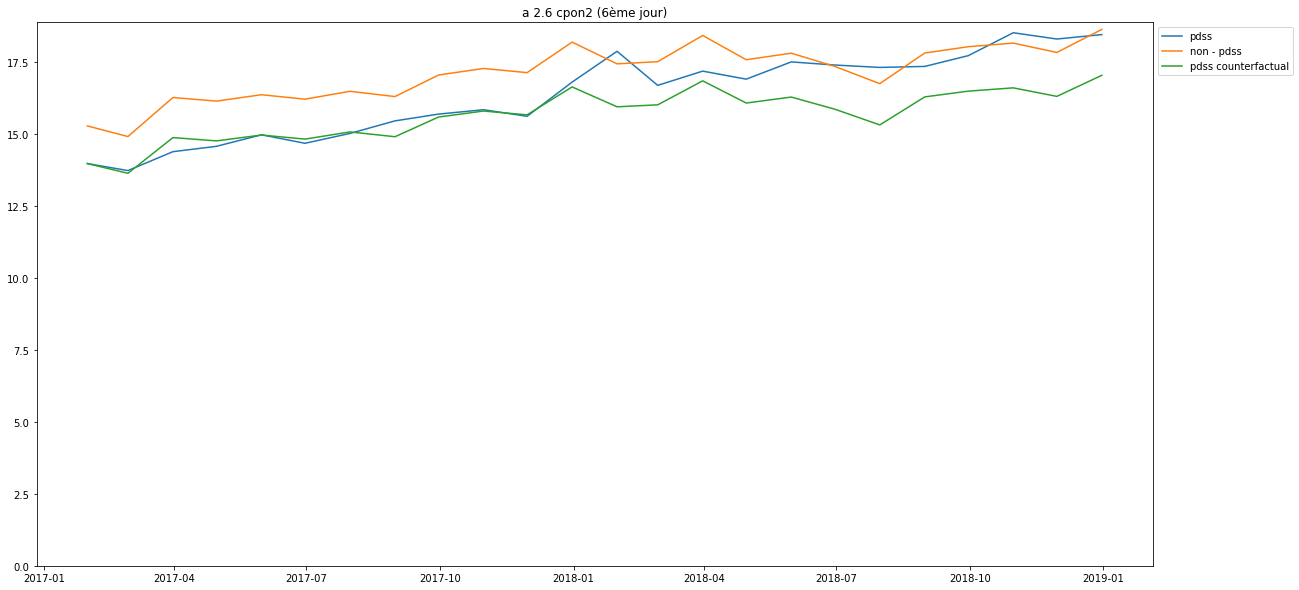

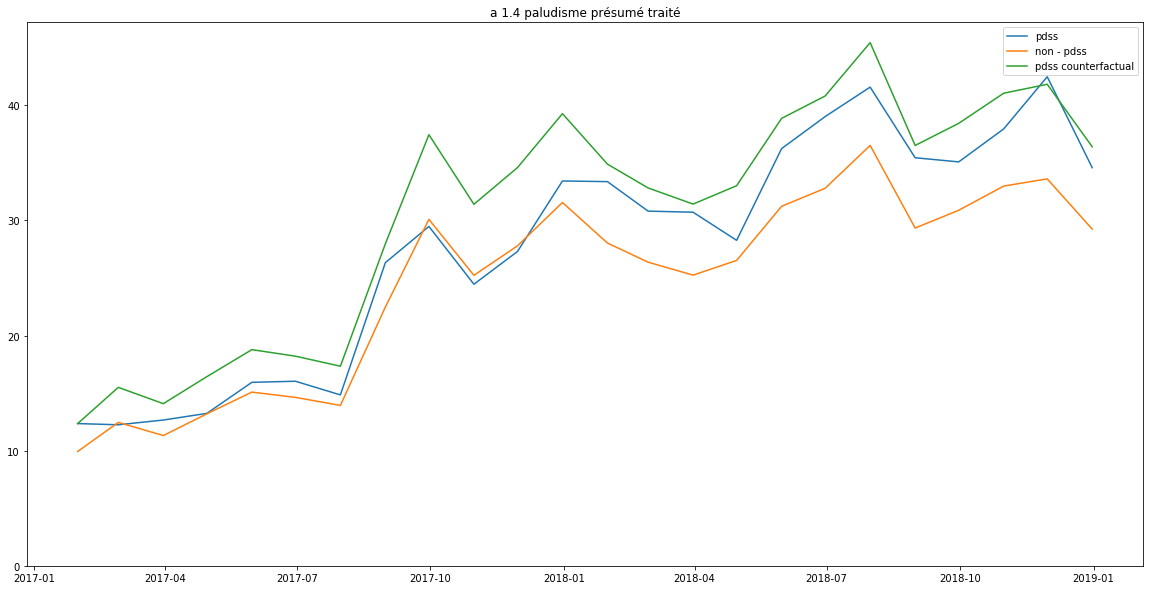

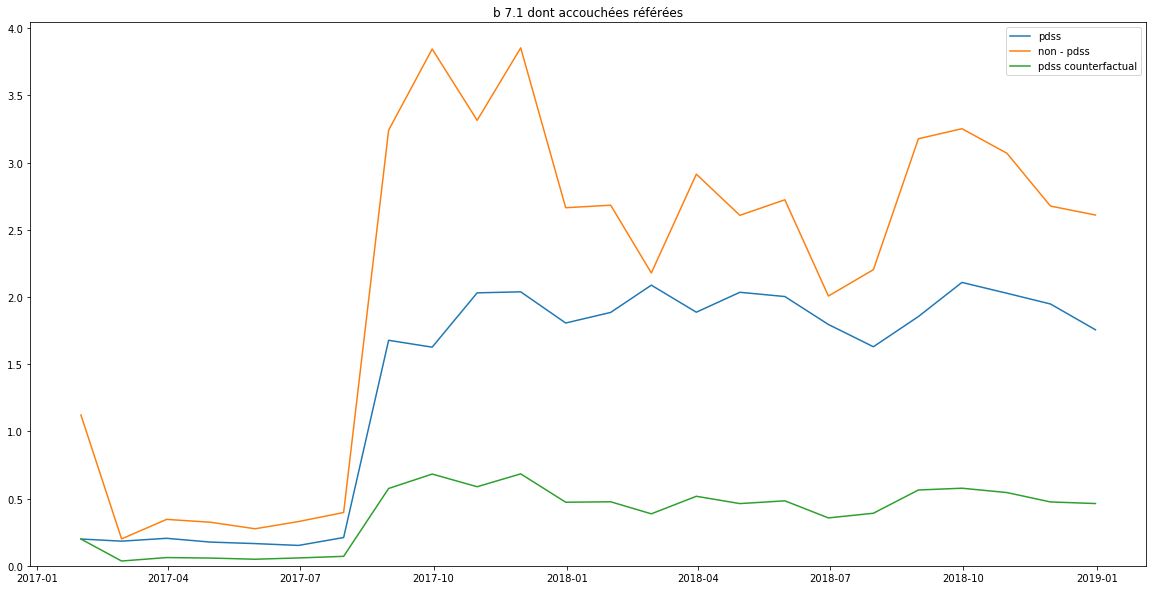

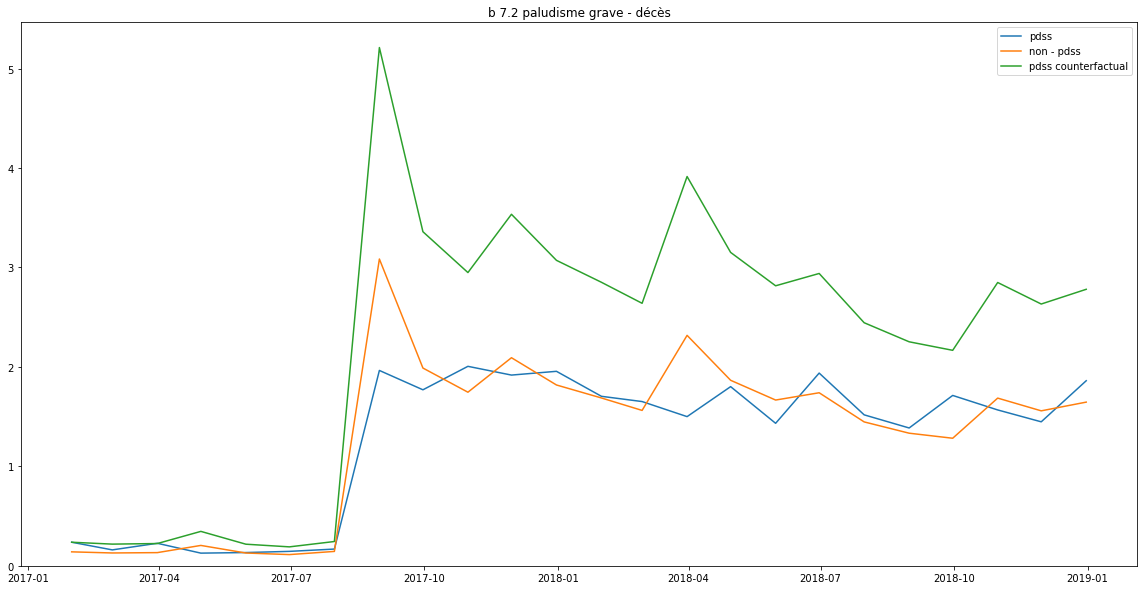

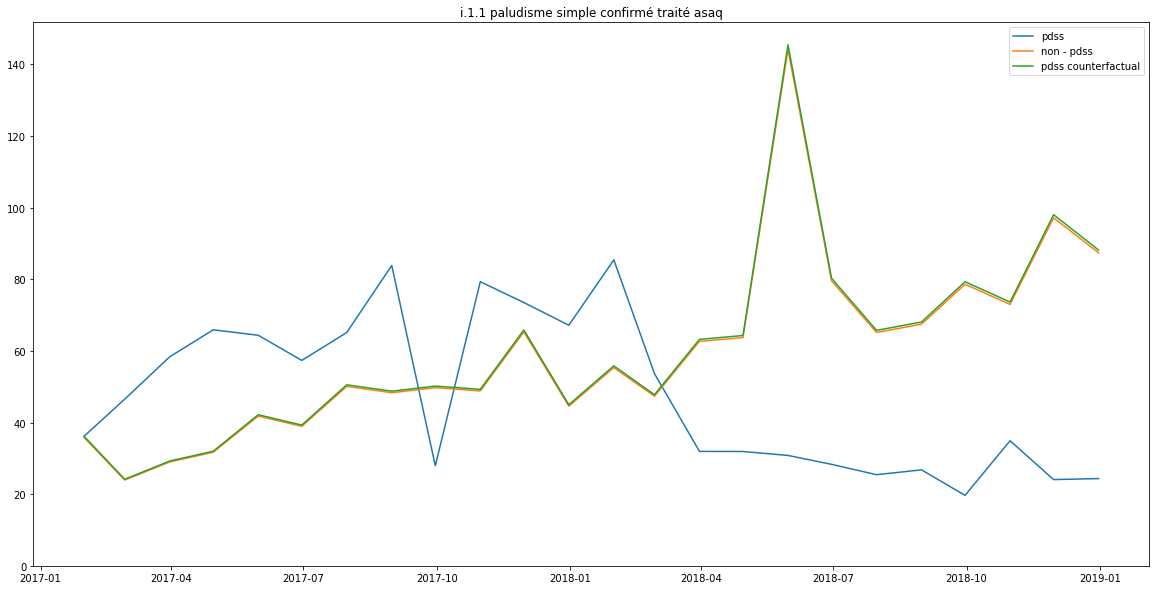

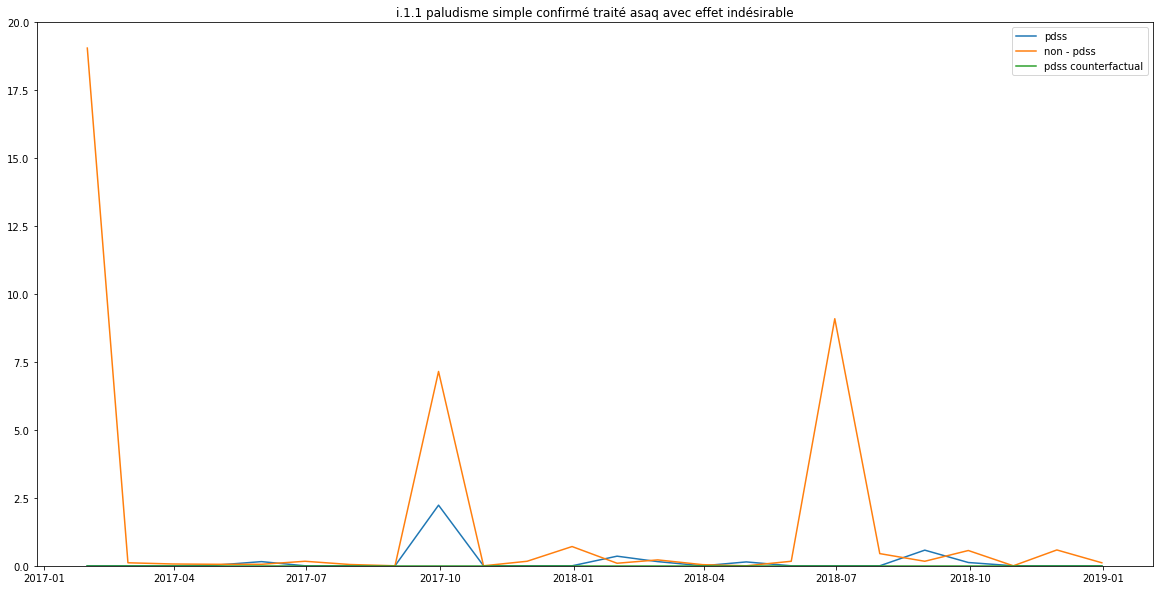

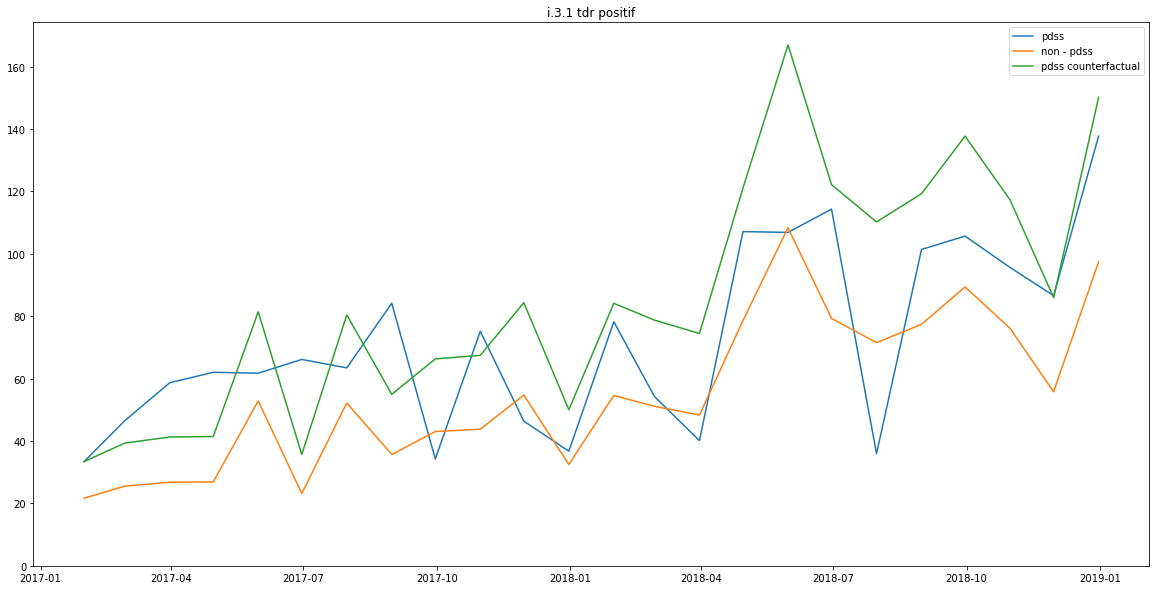

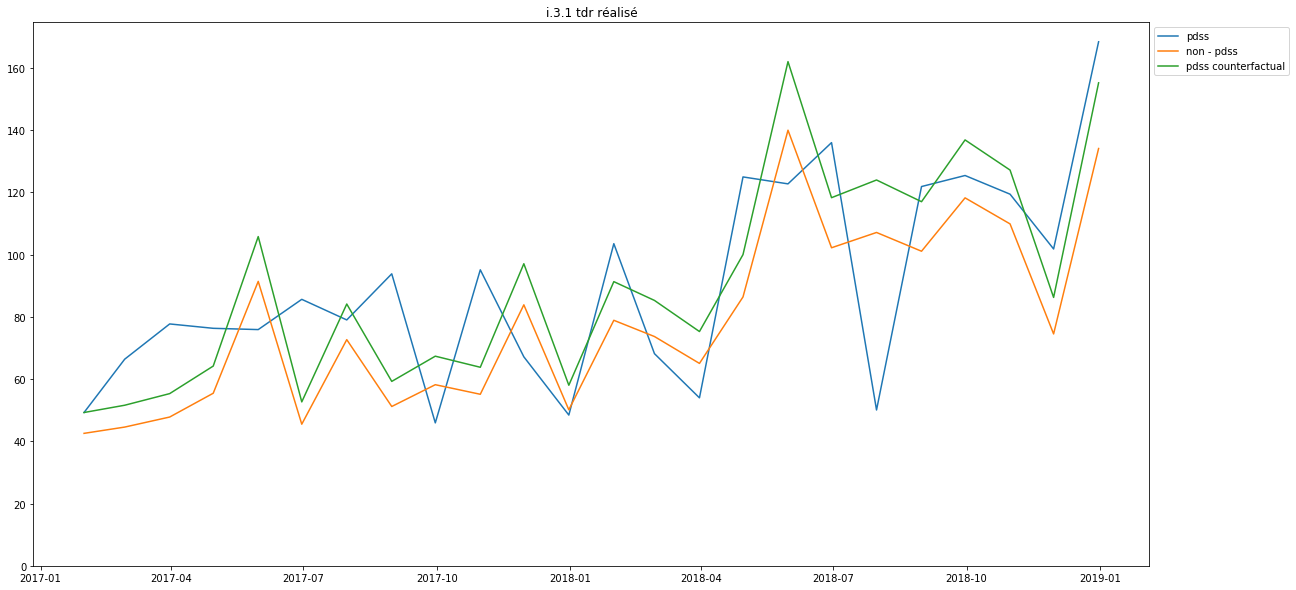

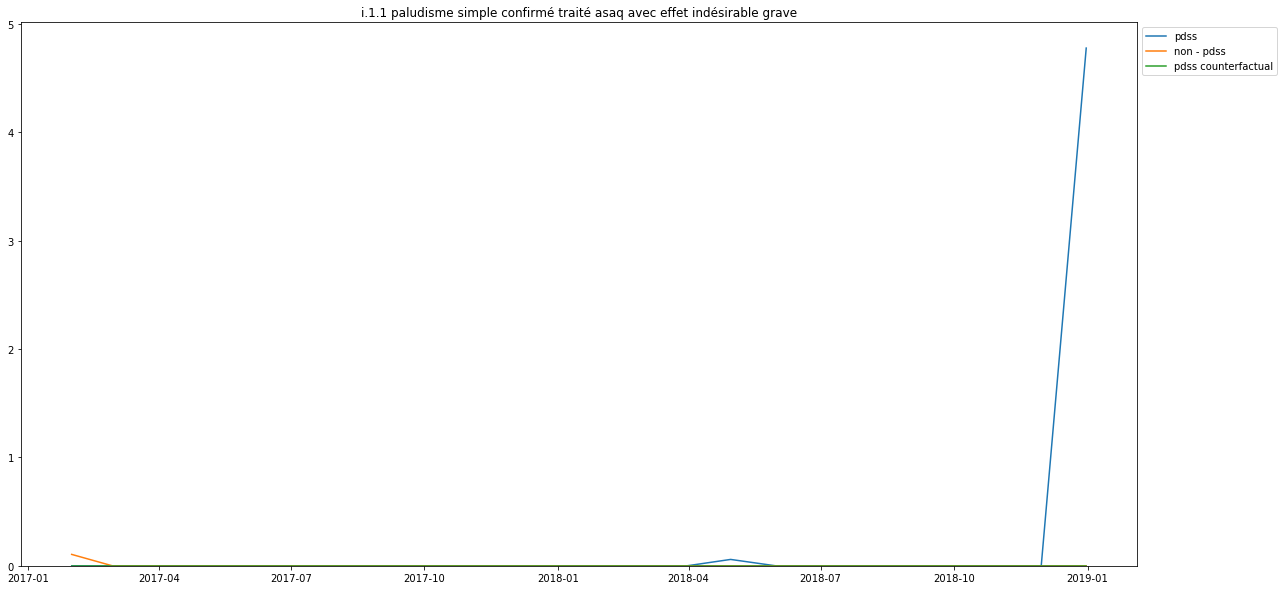

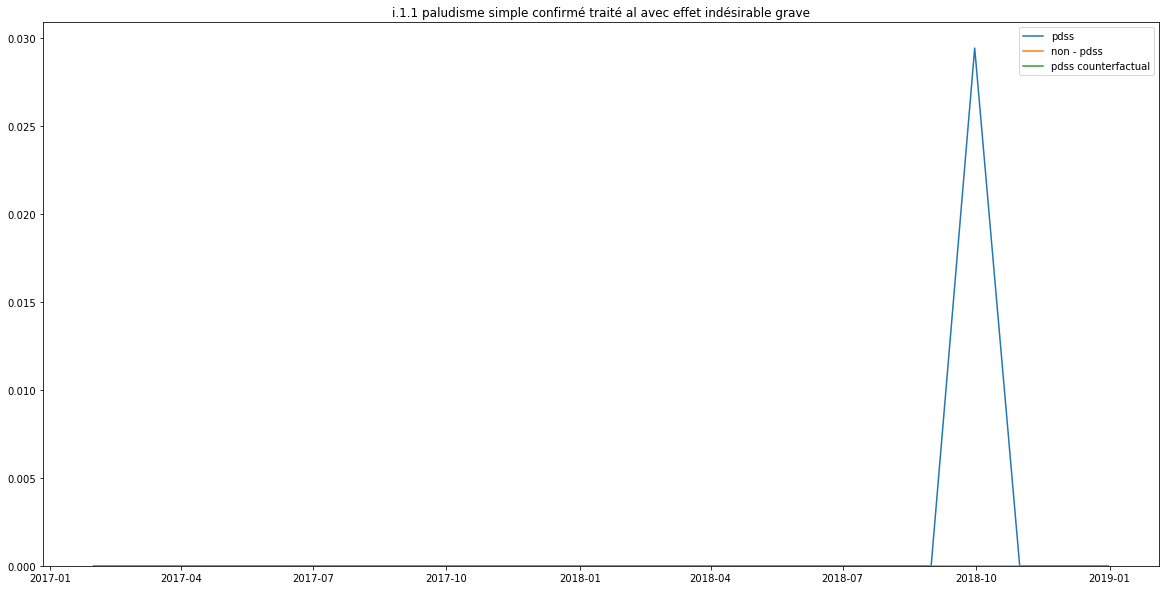

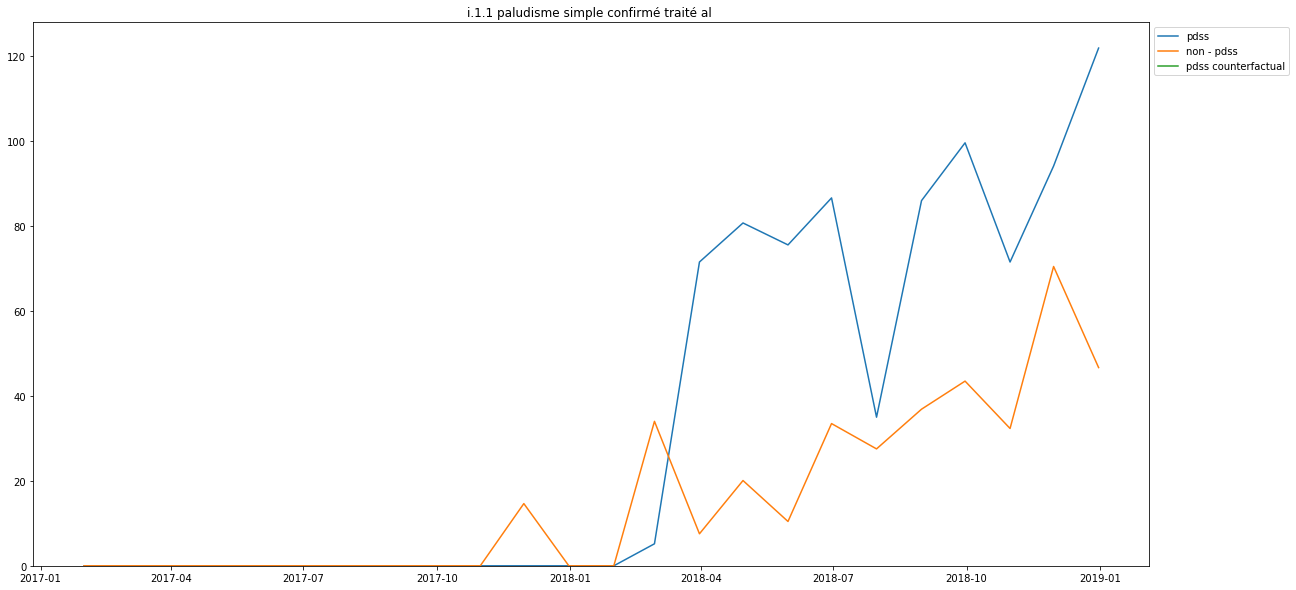

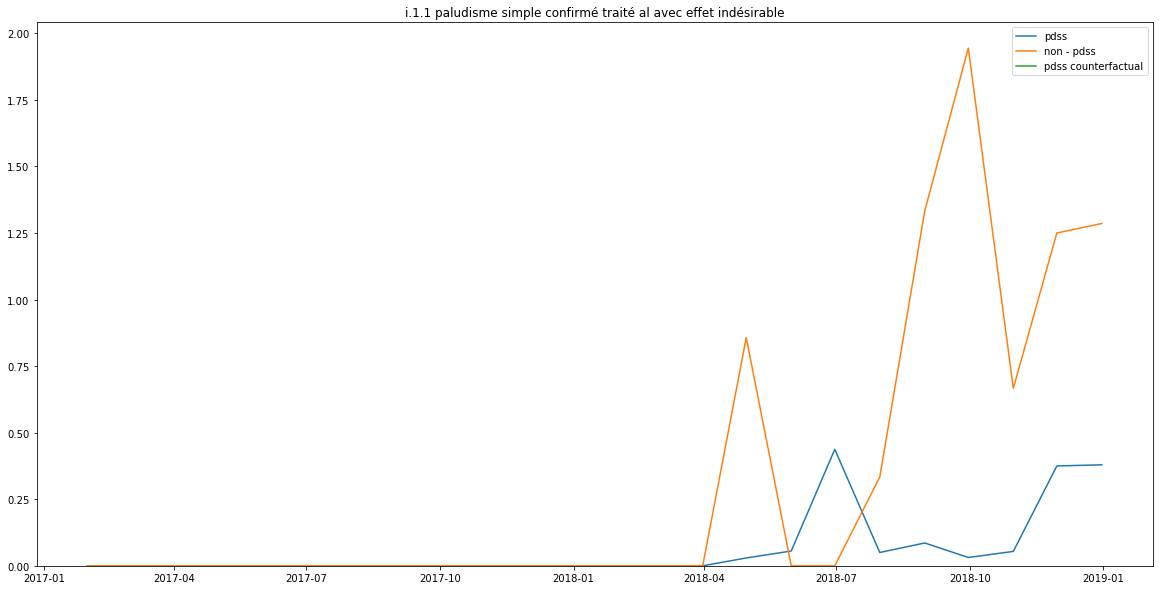

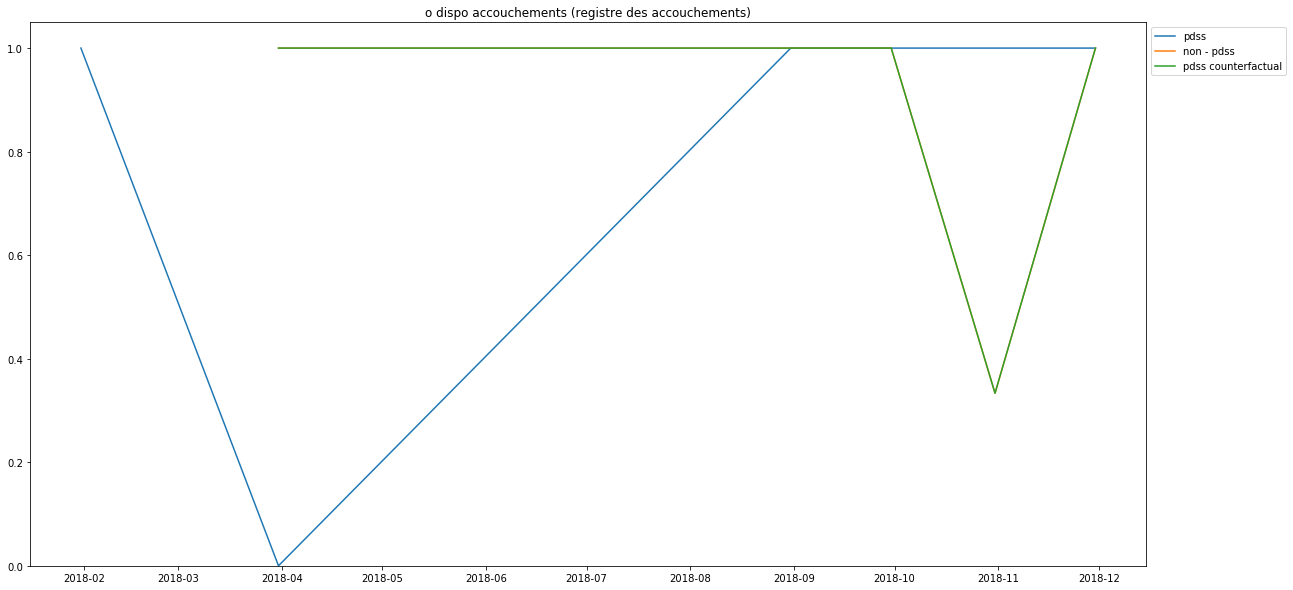

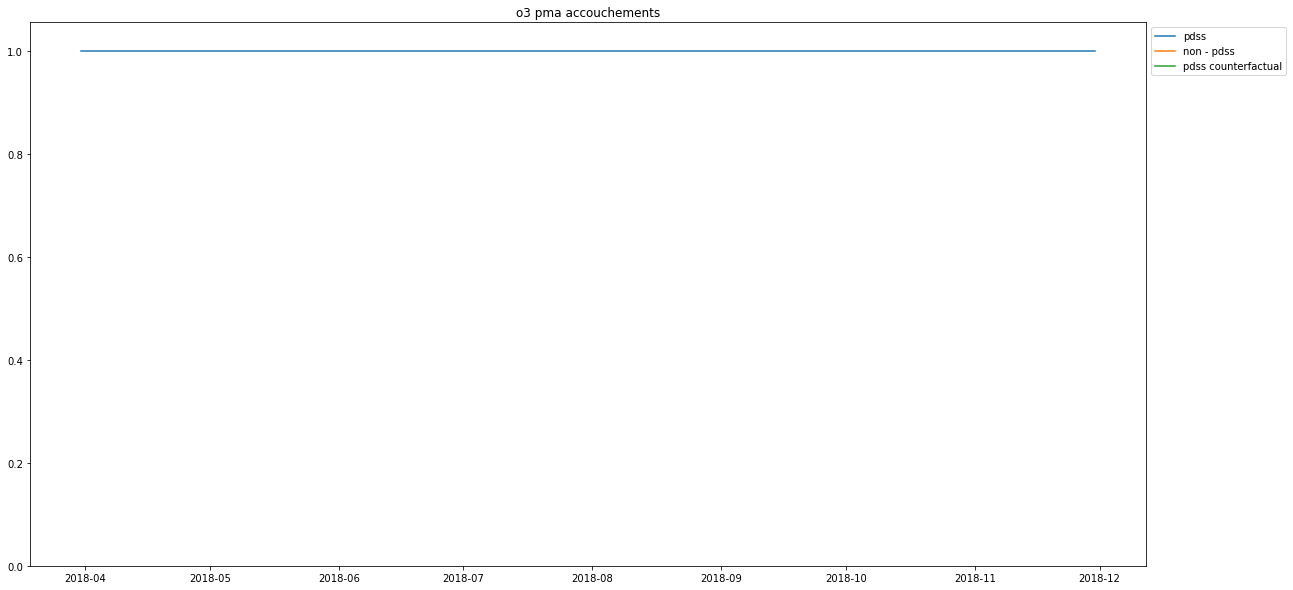

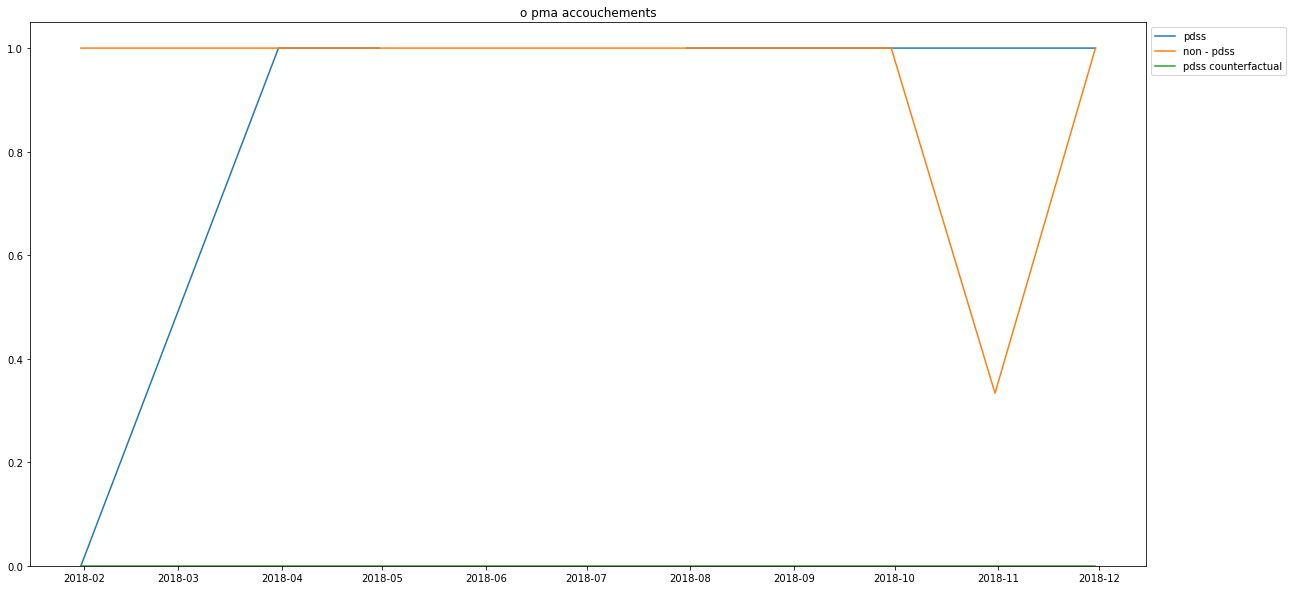

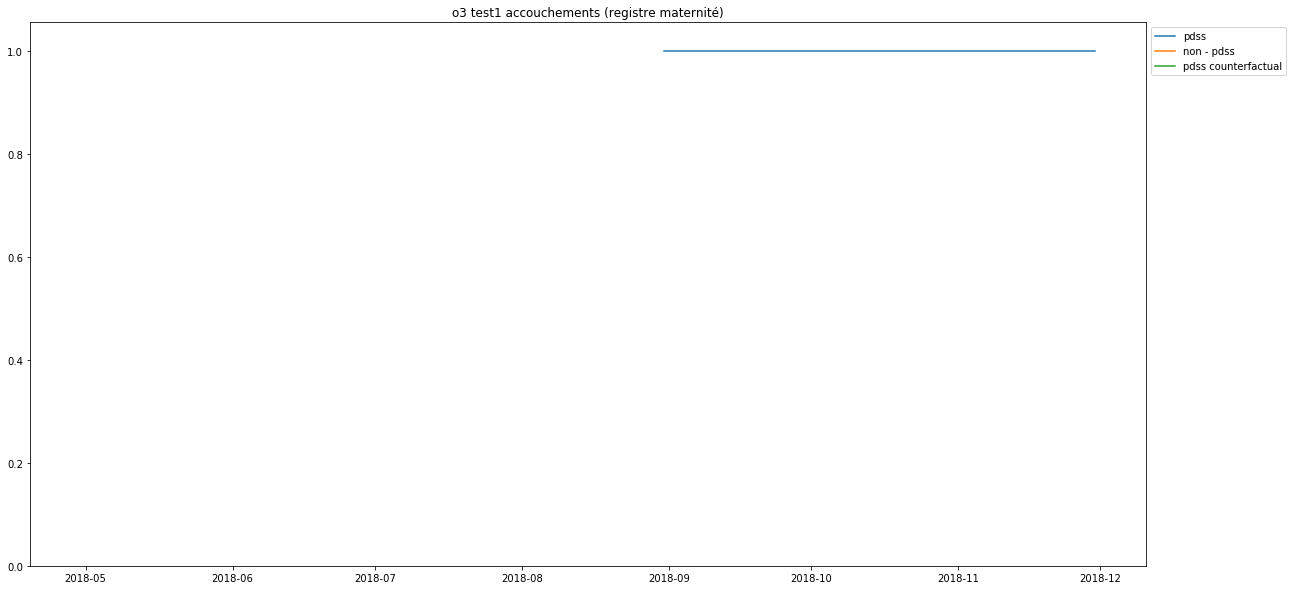

In [169]:
for indic in snis_pdss[~snis_pdss.dataelementname.str.contains('a 4.')].dataelementname.unique():
    print(indic)
    count = make_counterfactual(indic)
    make_counterfactual_plot(count,indic)

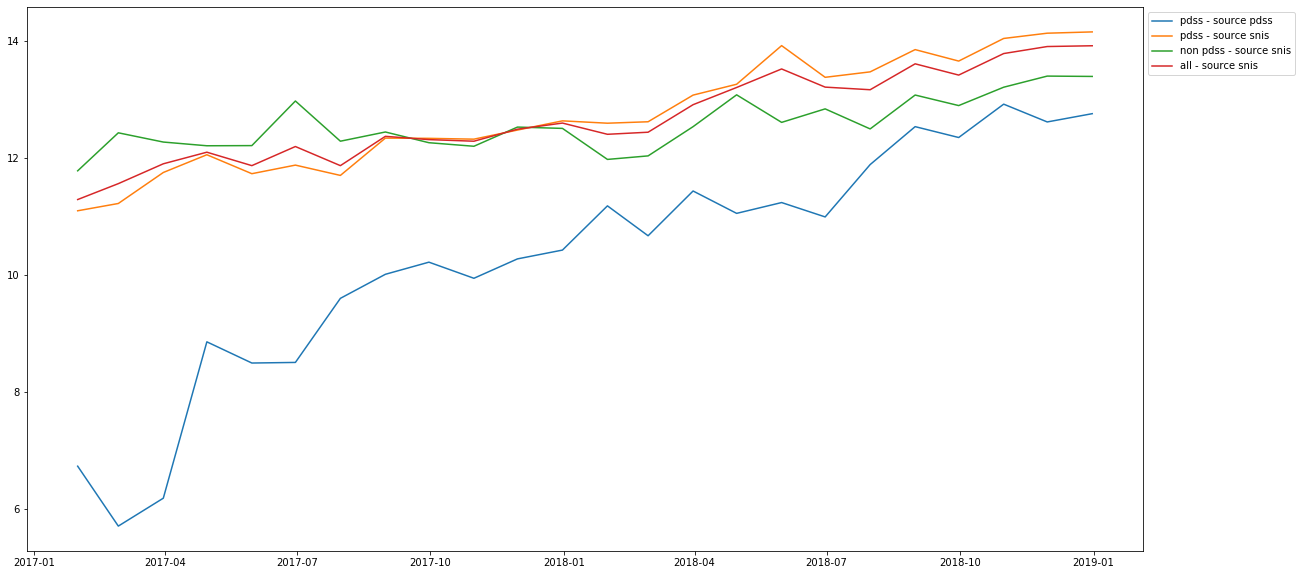

In [130]:
plt.figure(figsize = (20, 10))
plt.plot(pdss_anc_4_average.enddate, pdss_anc_4_average.value, label = "pdss - source pdss")
plt.plot(snis_pdss_anc_4_average.enddate, snis_pdss_anc_4_average.value, label = "pdss - source snis")
plt.plot(snis__non_pdss_anc_4_average.enddate, snis__non_pdss_anc_4_average.value, label = "non pdss - source snis")
plt.plot(snis_all_anc_4_average.enddate, snis_all_anc_4_average.value, label = "all - source snis")
plt.legend(bbox_to_anchor = (1,1))

In [142]:
ref = snis__non_pdss_anc_4_average[snis__non_pdss_anc_4_average.enddate == min(snis__non_pdss_anc_4_average.enddate)].value.iloc[0]
counterfactual = snis_pdss_anc_4_average.value[snis_pdss_anc_4_average.enddate == min(snis_pdss_anc_4_average.enddate)].iloc[0] * snis__non_pdss_anc_4_average.value / ref

In [141]:
snis_pdss_anc_4_average.value[snis_pdss_anc_4_average.enddate == min(snis_pdss_anc_4_average.enddate)]

0    11.098373
Name: value, dtype: float64

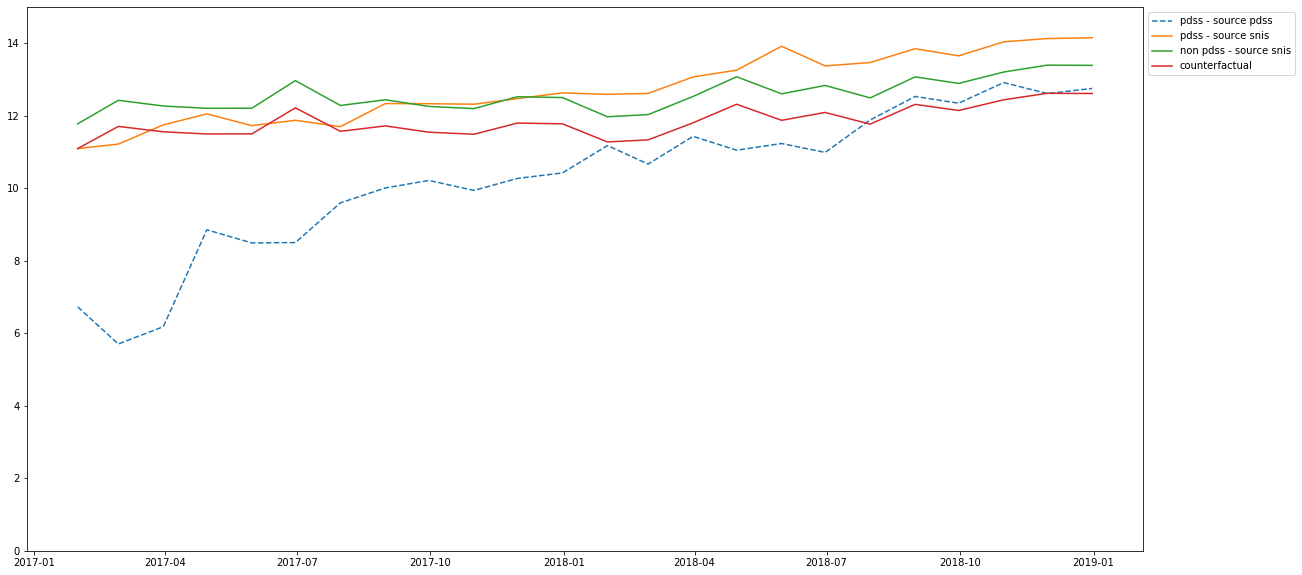

In [148]:
plt.figure(figsize = (20, 10))
plt.plot(pdss_anc_4_average.enddate, pdss_anc_4_average.value, "--", label = "pdss - source pdss", c=cmap(0))
plt.plot(snis_pdss_anc_4_average.enddate, snis_pdss_anc_4_average.value, label = "pdss - source snis")
plt.plot(snis__non_pdss_anc_4_average.enddate, snis__non_pdss_anc_4_average.value, label = "non pdss - source snis")
plt.plot(snis__non_pdss_anc_4_average.enddate, counterfactual, label = "counterfactual")
plt.ylim([0,15])
plt.legend(bbox_to_anchor = (1,1))

In [ ]:
pdss_full_values = pdss_extract.groupby(["dataelementname","uidlevel2","monthly"]).value.apply(sum)
pdss_complete_fosas = pdss_extract.groupby("uidorgunit").apply(select_fosa, .8, "201701","201901")#.reset_index()
pdss_complete_fosas_values = pdss_complete_fosas.groupby(["dataelementname","uidlevel2","monthly"]).value.apply(sum)

In [ ]:
pdss_full_values = pdss_full_values.reset_index().merge(pdss.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "monthly"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()
pdss_complete_fosas_values = pdss_complete_fosas_values.reset_index().merge(pdss.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "monthly"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()

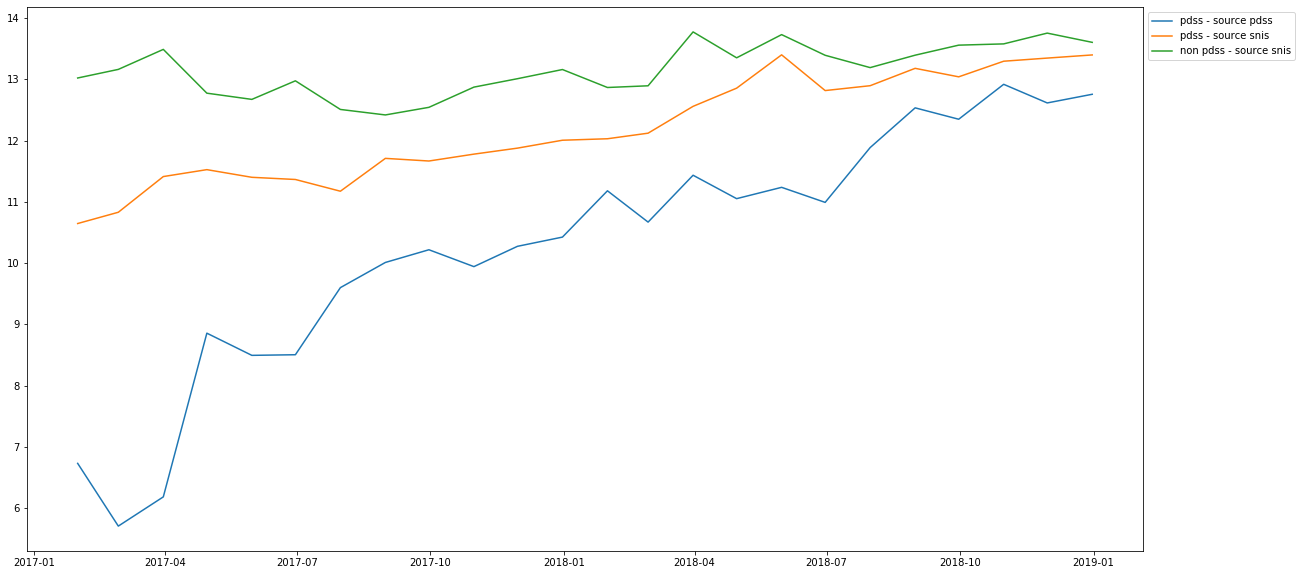

In [124]:
plt.figure(figsize = (20, 10))
plt.plot(pdss_anc_4_average.enddate, pdss_anc_4_average.value, label = "pdss - source pdss")
plt.plot(snis_pdss_anc_4_average.enddate, snis_pdss_anc_4_average.value, label = "pdss - source snis")
plt.plot(snis__non_pdss_anc_4_average.enddate, snis__non_pdss_anc_4_average.value, label = "non pdss - source snis")
plt.legend(bbox_to_anchor = (1,1))

## RBF Implementation

* Map of RBF extension
* Standardized new data
* Do counterfactual analysis

In [197]:
shape_rdc = "/Users/grlurton/Documents/data/dhis/rdc/snis/map_polygons.shp"
map_df = gpd.read_file(shape_rdc)

full_carte_sanitaire = pd.read_excel("/Users/grlurton/Documents/data/drc/carte_sanitaire.xlsx", 1)

splitted_coords = full_carte_sanitaire[~pd.isnull(full_carte_sanitaire.Coordinates)].Coordinates.str.replace("\[|\]","").str.split(",")
geolocs = pd.DataFrame({"long":splitted_coords.apply(lambda x: x[0]),
                        "lat":splitted_coords.apply(lambda x: x[1]), 
                        "id":full_carte_sanitaire.loc[~pd.isnull(full_carte_sanitaire.Coordinates),"Dhis2 Id"]})

geometry = [Point(xy) for xy in zip(geolocs.long.astype(float), geolocs.lat.astype(float))]

In [198]:
geo_df = gpd.GeoDataFrame(data=geolocs.id, 
                          crs={'init': 'epsg:2263'}, 
                          geometry=geometry)

In [253]:
provinces_df = map_df[map_df.org_unit_I.isin(snis.orgunitstructure.uidlevel2).tolist()]

In [254]:
provinces_df = provinces_df.merge(snis.organisationunit, left_on="org_unit_I", right_on="uid")
provinces_df.name = provinces_df.name.str.lower()

In [255]:
pdss_provinces = pdss.organisationunit[pdss.organisationunit.name.str.contains("DPS")]
pdss_provinces.name = pdss_provinces.name.str.lower().str.replace(" dps", " province")

In [260]:
provinces_df = provinces_df.merge(pdss_provinces, on='name', suffixes=["_snis", "_pdss"])

In [262]:
pdss_extract["year"] = pdss_extract.quarterly.str[0,4]
u = pdss_extract.groupby(["uidlevel2","quarterly"]).uidorgunit.nunique().reset_index()

In [265]:
to_map = provinces_df.merge(u, left_on = "uid_pdss", right_on="uidlevel2")

In [ ]:
to_map[to_map.quarterly == "2017Q1"].plot(column="uidorgunit", cmap=’Blues’, linewidth=0.8, ax=ax, edgecolor=’0.8')

In [107]:
snis_to_plot = snis_extract[snis_extract.dataelementname.isin(variables_dict.keys())]

In [172]:
snis_full_values = snis_extract.groupby(["dataelementname","uidlevel2","monthly"]).value.apply(sum)
snis_interpolated = snis_extract.groupby("dataelementname").apply(make_interpolated_dataset, "201701", "201901")
snis_interpolated_values = snis_interpolated.groupby(level = [0,1,3]).apply(sum)

KeyboardInterrupt: 

In [ ]:
snis_full_values = snis_full_values.reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "monthly"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()
snis_interpolated_values = snis_interpolated_values.reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "monthly"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()

In [ ]:
pdss_full_values.name = pdss_full_values.name.str.replace(" DPS","").str.strip()
pdss_complete_fosas_values.name = pdss_complete_fosas_values.name.str.replace(" DPS","").str.strip()
snis_full_values.name = snis_full_values.name.str.replace(" Province","").str.strip()
snis_interpolated_values.name = snis_interpolated_values.name.str.replace(" Province","").str.strip()

In [ ]:
pdss_full_values.monthly = pd.to_datetime(pdss_full_values.monthly,  format='%Y%m') + MonthEnd(1)
pdss_complete_fosas_values.monthly = pd.to_datetime(pdss_complete_fosas_values.monthly,  format='%Y%m') + MonthEnd(1)
snis_full_values.monthly = pd.to_datetime(snis_full_values.monthly,  format='%Y%m') + MonthEnd(1)

In [ ]:
compiled_data = pdss_full_values.merge(pdss_complete_fosas_values, on=["name","monthly","dataelementname"],
                                       how = "outer").merge(snis_full_values, on=["name","monthly","dataelementname"], how = "outer").merge(snis_interpolated_values, on=["name","monthly","dataelementname"], how = "outer")

In [ ]:
compiled_data.columns = ["dataelementname", "province", "month", "pdss_complete", "pdss_evolution", "snis_raw", "snis_interpolated"]
compiled_data = compiled_data[compiled_data.dataelementname.isin(["ANC4", "ANC1", "assisted_delivery"])]

In [ ]:
print(compiled_data[(compiled_data.month.dt.year == 2018)].groupby(["dataelementname"]).apply(lambda x: x.pdss_complete.sum() / x.snis_raw.sum()))
print(compiled_data[(compiled_data.month.dt.year == 2018)].groupby(["dataelementname"]).apply(lambda x: x.pdss_complete.sum() / x.snis_interpolated.sum()))

In [16]:
pdss_provinces = ["eq Equateur", "hk Haut Katanga", "hl Haut Lomami","ll Lualaba" , "mg Mongala", "mn Maniema", "nk Nord Kivu", "sk Sud Kivu", "su Sud Ubangi", "tu Tshuapa"]

print(compiled_data[(compiled_data.month.dt.year == 2018) & (compiled_data.province.isin(pdss_provinces))].groupby(["dataelementname", "province"]).apply(lambda x: x.pdss_complete.sum() / x.snis_raw.sum()))
print(compiled_data[(compiled_data.month.dt.year == 2018)& (compiled_data.province.isin(pdss_provinces))].groupby(["dataelementname", "province"]).apply(lambda x: x.pdss_complete.sum() / x.snis_interpolated.sum()))

dataelementname    province       
ANC1               eq Equateur        0.468167
                   hk Haut Katanga    0.116169
                   hl Haut Lomami     0.262605
                   ll Lualaba         0.324915
                   mg Mongala         0.458137
                   mn Maniema         0.163056
                   nk Nord Kivu       0.149191
                   sk Sud Kivu        0.134091
                   su Sud Ubangi      0.289307
                   tu Tshuapa         0.606392
ANC4               eq Equateur        0.395817
                   hk Haut Katanga    0.177009
                   hl Haut Lomami     0.175805
                   ll Lualaba         0.298379
                   mg Mongala         0.525830
                   mn Maniema         0.160313
                   nk Nord Kivu       0.246227
                   sk Sud Kivu        0.244993
                   su Sud Ubangi      0.231555
                   tu Tshuapa         0.539923
assisted_delivery  eq Equ

With the Programme de Développement du Système de Santé (PDSS), Results Based Funding (RBF) is playing an important role in the evolution of service provision in the DRC. In 2018, we estimate that around 15% of deliveries in the country were provided through PDSS funded facilities, as well as around 10% of ANC visits. When looking to provinces in which the PDSS is implemented, this proportion gets even higher. We estimated that PDSS funds well over 50% of assisted deliveries in the Equateur and Tshuapa provinces and over a third of first ANC visits in those provinces and the Mongala Province. 

Figure 1 also shows how this share of RBF funded service provision has rapidly grown in 2017, and has then followed a somewhat slower growth in 2018. 

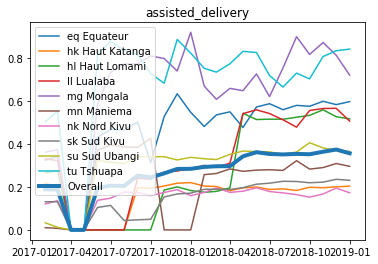

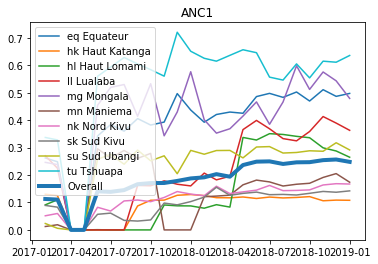

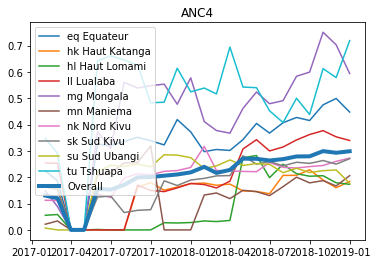

In [17]:
for serie in compiled_data.dataelementname.unique():
    fig1 = plt.figure()
    dat_p = compiled_data[(compiled_data.dataelementname == serie) & (compiled_data.province.isin(pdss_provinces))]
    dat_p2 = dat_p.groupby(["province", "month"]).apply(lambda x: x.pdss_complete.sum()/x.snis_raw.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province in pdss_provinces:
        plt.plot(dat_p2.loc[dat_p2.province == province,"month"],dat_p2.loc[dat_p2.province == province,"value"], label = province)
    dat_pn = dat_p.groupby(["month"]).apply(lambda x: x.pdss_complete.sum()/x.snis_raw.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    plt.plot(dat_pn.month,dat_pn.value, label = "Overall", linewidth = 4)
    plt.legend()
    plt.title(serie)

This trend is due to two phenomenons. First, as shown in figure 2, we see a slow growth in service provision at national level. At national level, assisted delivery as increased by 16% between january 2017 and december 2018. ANC1 has remained at the same levels, and ANC4 has increased 12%. By comparison, in facilities that started the RBF program in early 2017, we see a 73% increase in the number of assisted delivery a 58% increase in ANC1 attendance and a doubling of ANC4 attendance. 

The augmentation of the share of RBF funded service delivery is thus due to a dual phenomenon: a progressive extension of the number of the number of zones included in the RBF program, and an increase in service delivery in the selected facilities.

assisted_delivery : 1.163634684643088
ANC1 : 1.0092272202998847
ANC4 : 1.1217883615528035


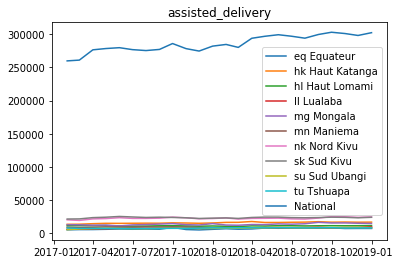

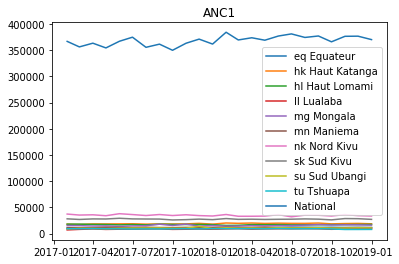

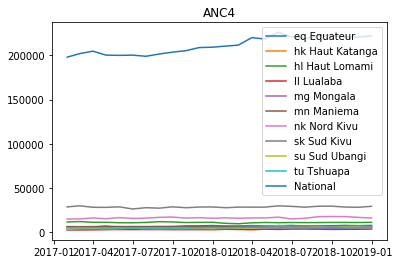

In [18]:
for serie in compiled_data.dataelementname.unique():
    fig1 = plt.figure()
    dat_p = compiled_data[(compiled_data.dataelementname == serie)]
    dat_p2 = dat_p.groupby(["province", "month"]).apply(lambda x: x.snis_interpolated.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province in pdss_provinces:
        plt.plot(dat_p2.loc[dat_p2.province == province,"month"],dat_p2.loc[dat_p2.province == province,"value"], label = province)
    dat_pn = dat_p.groupby(["month"]).apply(lambda x: x.snis_interpolated.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    print(serie + " : " + str(dat_pn.value[dat_pn.month == "2018-12-31"].iloc[0] / dat_pn.value[dat_pn.month == "2017-01-31"].iloc[0]))
    plt.plot(dat_pn.month,dat_pn.value, label = "National")
    plt.legend()
    plt.title(serie)

In [20]:
for serie in compiled_data.dataelementname.unique():
    dat_pn = compiled_data[compiled_data.dataelementname == serie].groupby(["month"]).apply(lambda x: x.pdss_evolution.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    print(serie + " : " + str(dat_pn.value[dat_pn.month == "2018-12-31"].iloc[0] / dat_pn.value[dat_pn.month == "2017-01-31"].iloc[0]))

assisted_delivery : 1.7643798095734968
ANC1 : 1.6059716196502662
ANC4 : 2.307455927543264


In [ ]:
snis_to_plot =  snis_to_plot.merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")

In [112]:
snis_to_plot.value = snis_to_plot.value.astype(float)
snis_full_values = snis_to_plot.groupby(["dataelementname","uidlevel2","monthly"]).value.apply(sum)
snis_interpolated = snis_to_plot.groupby("dataelementname").apply(make_interpolated_dataset, "201701", "201901")
snis_interpolated_values = snis_to_plot.groupby(level = [0,1,3]).apply(sum)

ValueError: multiple levels only valid with MultiIndex

a 2.3 accouchements par personnel qualifié : 1.2613432409812828
a 2.1 cpn 4 : 1.2132340389211336
a 2.1 cpn 1 : 1.0343780471757635


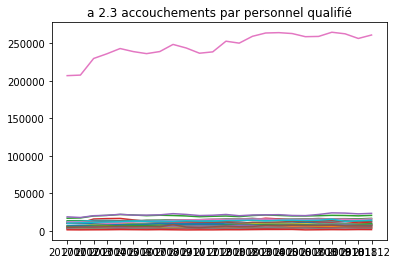

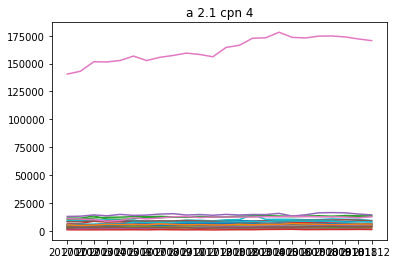

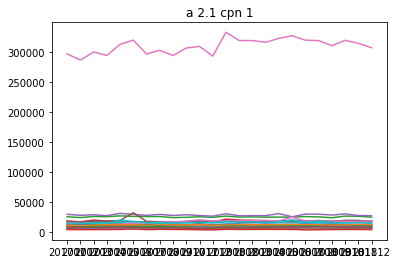

In [133]:
#snis_full_values = snis_full_values.reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")
for serie in snis_to_plot.dataelementname.unique():
    fig1 = plt.figure()
    dat_p = snis_full_values[(snis_full_values.dataelementname == serie)]
    dat_p2 = dat_p.groupby(["name_y", "monthly"]).apply(lambda x: x.value.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province in snis_to_plot.name.unique():
        plt.plot(dat_p2.loc[dat_p2.name_y == province,"monthly"],dat_p2.loc[dat_p2.name_y == province,"value"], label = province)
    dat_pn = dat_p.groupby(["monthly"]).apply(lambda x: x.value.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    print(serie + " : " + str(dat_pn.value[dat_pn.monthly == "201812"].iloc[0] / dat_pn.value[dat_pn.monthly == "201701"].iloc[0]))
    plt.plot(dat_pn.monthly,dat_pn.value, label = "National")
   # plt.legend()
    plt.title(serie)

In [ ]:
for serie in snis_to_plot.dataelementname.unique():
    fig1 = plt.figure()
    dat_p = snis_full_values[(snis_interpolated_values.dataelementname == serie)]
    dat_p2 = dat_p.groupby(["province", "month"]).apply(lambda x: x.dat_p.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province in snis_to_plot.name.unique():
        plt.plot(dat_p2.loc[dat_p2.province == province,"month"],dat_p2.loc[dat_p2.province == province,"value"], label = province)
    dat_pn = dat_p.groupby(["month"]).apply(lambda x: x.snis_interpolated_values.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    print(serie + " : " + str(dat_pn.value[dat_pn.month == "2018-12-31"].iloc[0] / dat_pn.value[dat_pn.month == "2017-01-31"].iloc[0]))
    plt.plot(dat_pn.month,dat_pn.value, label = "National")
    plt.legend()
    plt.title(serie)

Number of facilitires: evolutiokn / map

Growth accross country


Sensitibvity analysis on monetary amounts


* Map for rbf extensions
 
* Cleaned RBF contribution to total services

* availibty of input on SNIS

* Contrat unique provinces

* Check all data composition
    * CS vs Hospital
    * period validity

     uidlevel2 quarterly  uidorgunit
0  BmKjwqc6BEw    2017Q1         241
1  BmKjwqc6BEw    2017Q2         242
2  BmKjwqc6BEw    2017Q3         242
3  BmKjwqc6BEw    2017Q4         239
4  BmKjwqc6BEw    2018Q1         238
5  BmKjwqc6BEw    2018Q2         238
6  BmKjwqc6BEw    2018Q3         238
7  BmKjwqc6BEw    2018Q4         284
      uidlevel2 quarterly  uidorgunit
8   F9w3VW1cQmb    2017Q1         109
9   F9w3VW1cQmb    2017Q2           1
10  F9w3VW1cQmb    2017Q3         109
11  F9w3VW1cQmb    2017Q4         109
12  F9w3VW1cQmb    2018Q1         108
13  F9w3VW1cQmb    2018Q2         108
14  F9w3VW1cQmb    2018Q3         108
15  F9w3VW1cQmb    2018Q4         108
      uidlevel2 quarterly  uidorgunit
16  GnLX8MNgxZw    2017Q1         141
17  GnLX8MNgxZw    2017Q2         120
18  GnLX8MNgxZw    2017Q3          38
19  GnLX8MNgxZw    2017Q4         129
20  GnLX8MNgxZw    2018Q1         151
21  GnLX8MNgxZw    2018Q2         159
22  GnLX8MNgxZw    2018Q3         160
23  GnLX8MNgxZw    20

In [227]:
pdss_extract.quarterly.str.s

value    uidlevel3    uidlevel2     enddate monthly quarterly  \
0        11.0  Vq92HU5Qo8W  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
1         0.0  Vq92HU5Qo8W  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
2         0.0  Vq92HU5Qo8W  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
3         0.0  Vq92HU5Qo8W  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
4        30.0  Yku6XCkfcUP  pIAYIpy4hiH  2017-11-30  201711    2017Q4   
5         4.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
6         8.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
7         0.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
8         4.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
9         2.0  dR51zsm2j46  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
10        9.0  dR51zsm2j46  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
11        0.0  dR51zsm2j46  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
12        7.0  dR51zsm2j46  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
13        0.0  dR51zsm2j46  ym2K6YcSNl9  2017-07-31  201707    2017Q3   
14        0.0  dR51zsm2j46  ym2K6YcSNl9  2017-07-31  201707    2017Q3   
15        0.0  dR51zsm2j46  ym2K6YcSNl9  2017-07-31  201707    2017Q3   
16        6.0  dR51zsm2j46  ym2K6YcSNl9  2017-07-31  201707    2017Q3   
17        9.0  dR51zsm2j46  ym2K6YcSNl9  2017-07-31  201707    2017Q3   
18        0.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
19        0.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
20        7.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
21       33.0  dR51zsm2j46  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
22       20.0  dR51zsm2j46  ym2K6YcSNl9  2017-09-30  201709    2017Q3   
23       12.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
24        8.0  dR51zsm2j46  ym2K6YcSNl9  2017-08-31  201708    2017Q3   
25       27.0  Yku6XCkfcUP  pIAYIpy4hiH  2017-12-31  201712    2017Q4   
26       23.0  Yku6XCkfcUP  pIAYIpy4hiH  2017-11-30  201711    2017Q4   
27      206.0  Yku6XCkfcUP  pIAYIpy4hiH  2017-12-31  201712    2017Q4   
28       51.0  Yku6XCkfcUP  pIAYIpy4hiH  2017-11-30  201711    2017Q4   
29       48.0  Yku6XCkfcUP  pIAYIpy4hiH  2017-10-31  201710    2017Q4   
...       ...          ...          ...         ...     ...       ...   
421222    0.0  mOH4TWKHnQW  u0vP3ZicczY  2018-10-31  201810    2018Q4   
421223    0.0  mOH4TWKHnQW  u0vP3ZicczY  2018-11-30  201811    2018Q4   
421224    0.0  mOH4TWKHnQW  u0vP3ZicczY  2018-12-31  201812    2018Q4   
421225   11.0  mwFPZxgRMJO  u0vP3ZicczY  2018-12-31  201812    2018Q4   
421226   12.0  CvH9ZlChPMD  u0vP3ZicczY  2018-10-31  201810    2018Q4   
421227   32.0  CvH9ZlChPMD  u0vP3ZicczY  2018-12-31  201812    2018Q4   
421228   11.0  CvH9ZlChPMD  u0vP3ZicczY  2018-11-30  201811    2018Q4   
421229   10.0  CvH9ZlChPMD  u0vP3ZicczY  2018-11-30  201811    2018Q4   
421230   13.0  CvH9ZlChPMD  u0vP3ZicczY  2018-11-30  201811    2018Q4   
421231  221.0  CvH9ZlChPMD  u0vP3ZicczY  2018-12-31  201812    2018Q4   
421232   18.0  CvH9ZlChPMD  u0vP3ZicczY  2018-11-30  201811    2018Q4   
421233  136.0  CvH9ZlChPMD  u0vP3ZicczY  2018-12-31  201812    2018Q4   
421234   21.0  CvH9ZlChPMD  u0vP3ZicczY  2018-10-31  201810    2018Q4   
421235    0.0  CvH9ZlChPMD  u0vP3ZicczY  2018-10-31  201810    2018Q4   
421236   17.0  CvH9ZlChPMD  u0vP3ZicczY  2018-10-31  201810    2018Q4   
421237   14.0  CvH9ZlChPMD  u0vP3ZicczY  2018-10-31  201810    2018Q4   
421238   28.0  CvH9ZlChPMD  u0vP3ZicczY  2018-10-31  201810    2018Q4   
421239    0.0  CvH9ZlChPMD  u0vP3ZicczY  2018-10-31  201810    2018Q4   
421240   16.0  CvH9ZlChPMD  u0vP3ZicczY  2018-11-30  201811    2018Q4   
421241   22.0  CvH9ZlChPMD  u0vP3ZicczY  2018-12-31  201812    2018Q4   
421242    3.0  CvH9ZlChPMD  u0vP3ZicczY  2018-12-31  201812    2018Q4   
421243    0.0  CvH9ZlChPMD  u0vP3ZicczY  2018-12-31  201812    2018Q4   
421244    0.0  CvH9ZlChPMD  u0vP3ZicczY  2018-11-30  201811    201